# Thank you Because Project

Content Analysis for Thank you Because Project, By Chu Zhuang, Sruti Kanthan

-------------------------------
#### Outline: 
1. Import Data

2. Linguistic Feature Analysis and Linear Regression

3. Pairwise Similarity across time     
    3.1 Linguistic Features    
    3.2 Word Embeddings
    
4. Feature Score changes across time     
    4.1 Linguistic Features    
    4.2 Word Embeddings

In [336]:
import pandas
import pandas as pd
import numpy as np
import lucem_illud_2020
import matplotlib.pyplot as plt #For graphics

import gensim#For word2vec, etc
import math
import seaborn as sns
import sklearn.metrics.pairwise #For cosine similarity

### Import Data

For the Thank you Because project, we have 80pairs transcription (41 in TYB condition, 40 in NB condition). Each transcription is around 500 words, has two agents (Person A and B), happened in 3 mins.

After manually check the begining and the end of the conversation to make sure they are all on topic, we extract the following information from the transcripts: 

1. Agent of Each Turn
2. Utterance of Each Turn 
3. Timestamp of Each Turn (subtracted the timestamp of the first utterance)
4. Interjection of Each Turn (counted as the beginning of the next turn)

Also, to make sure each turn is a compelete expression of meaning, we further treated each line less than 15 characters as an interjection and converged texts before and after it of the other person.

In [2]:
#Load the data info 
import re

text_file='TYB_info.txt'
with open(text_file, encoding='utf-8') as f:
    lines=f.readlines()
    
pair_id=[]
condition=[]
topic=[]

for line in lines[1:]:
    line_sp=line.split('\t')
    pair_id.append(line_sp[0])
    condition.append(line_sp[1])
    topic.append(re.sub(r'\n','',line_sp[2]))

In [3]:
#organize the data info, version3.5
file_num=pair_id
num_of_file=len(file_num)
#condition=['NB','TYB','NB','TYB','TYB','NB','NB','TYB','TYB','TYB','NB']
#topic=[11,11,2,2,5,7,7,13,13,11,11]

conversation_txt_all,conversation_txt_A_all,conversation_txt_B_all,conversation_txt_A_all0,conversation_txt_B_all0=[],[],[],[],[]
round_info_A_all,round_info_B_all,inter_num_A_all,inter_num_B_all,time_info_A_all,time_info_B_all=[],[],[],[],[],[]

# read each file 
for i in range(num_of_file):
    filename='Transcripts/'+file_num[i]+'_otter.ai.txt'
    with open(filename, 'r',encoding='utf-8') as f:  #utf-8
        lines=f.readlines()
    
    conversation_txt,conversation_txt_A,conversation_txt_B=[],[],[]
    round_A,round_B,time0,time_flag_0=0,0,0,0
    time_A,time_B,time_flag_A,time_flag_B,time0_flag=0,0,0,0,0
    time_info_A,time_info_B,round_info_A,round_info_B,inter_num_A,inter_num_B=[],[],[],[],[],[]
    conversation_txt_A_in1,conversation_txt_B_in1=[],[]
    conversation_txt_A_in0,conversation_txt_B_in0='',''
    lineB0,lineA0=[],[]
    inter_A,inter_B=0,0
    l_len=len(lines)
    for i,line in enumerate(lines):
        re_other=r'\[(P|p)erson (A|B):(.*?)\]'
        re_other2=r'\[Speaker (1|2):(.*?)\]'
        find_other=re.findall(re_other,line)
        find_other2=re.findall(re_other2,line)
        line=re.sub(re_other,'.', line)
        line=re.sub(re_other2,'.', line)
        conversation_txt_A_in=[]
        conversation_txt_B_in=[]
        for other in find_other2: #speaker
            other_content=other[1]
            if person_id=='A':
                inter_B+=1
                conversation_txt_B_in.append(other_content)
            elif person_id=='B':
                inter_A+=1
                conversation_txt_A_in.append(other_content)                   

        for other in find_other:
            other_id=other[1]
            other_content=other[2]
            if other_id=='A':
                inter_A+=1
                #if len(other_content)>8:
                conversation_txt_A_in.append(other_content)
                #conversation_txt_A_in.append(other_content)
                #print(conversation_txt_A)
            elif other_id=='B':
                inter_B+=1
                #if len(other_content)>8:
                conversation_txt_B_in.append(other_content)
                #conversation_txt_B_in.append(other_content)
        
        re_person=r'Person (A|B)  (\d:\d{2})'
        find_person=re.findall(re_person,line)
        if find_person:
            person_id=find_person[0][0]
            timestamp0=find_person[0][1]
            c1,c2,c3=int(timestamp0[0]),int(timestamp0[2]),int(timestamp0[3])
            timestamp1=c1*60+c2*10+c3
            if time0_flag==0:
                time0=timestamp1
                time0_flag=1
            if person_id=='A'and time_flag_A==0:
                time_A=timestamp1-time0
                time_flag_A=1
            elif person_id=='B'and time_flag_B==0:
                time_B=timestamp1-time0
                time_flag_B=1
        else:
            line=re.sub(r'\n','',line)
            line=re.sub(r'--',' ',line)
            line=re.sub(r"\"",' ',line)
            line=re.sub(r'Transcribed by https://otter.ai','',line)
            if line:
                line0=line
                if person_id=='A':
                    if len(conversation_txt_B_in)!=0:
                        line0=line0+'.'+'.'.join(conversation_txt_B_in)
                    conversation_txt.append(line0)  
                if person_id=='B':
                    if len(conversation_txt_A_in)!=0:
                        line0=line0+'.'+'.'.join(conversation_txt_A_in)
                    conversation_txt.append(line0)                      
                    
                if len(line)<15:
                    if person_id=='A':
                        conversation_txt_A_in0=conversation_txt_A_in0+'. '+line
                        if len(conversation_txt_B_in0)==0 and len(conversation_txt_B)!=0:
                            lineB0=conversation_txt_B[-1]
                            a=conversation_txt_B.pop()
                            #if a:
                            round_B=round_B-1
                            time_B=time_info_B[-1]
                            time_flag_B=1
                            time_info_B.pop()
                            round_info_B.pop()
                            conversation_txt_B_in0=conversation_txt_B_in0+lineB0+'.'.join(conversation_txt_B_in)
                            
                        else:
                            conversation_txt_B_in0=conversation_txt_B_in0+'.'.join(conversation_txt_B_in)

                    if person_id=='B':
                        conversation_txt_B_in0=conversation_txt_B_in0+'. '+line
                        if len(conversation_txt_A_in0)==0 and len(conversation_txt_A)!=0:
                            lineA0=conversation_txt_A[-1]
                            a=conversation_txt_A.pop()
                            #if a:
                            round_A=round_A-1
                            time_A=time_info_A[-1]
                            time_flag_A=1
                            time_info_A.pop()
                            round_info_A.pop()
                            conversation_txt_A_in0=conversation_txt_A_in0+lineA0+'.'.join(conversation_txt_A_in)
                        else:
                            conversation_txt_A_in0=conversation_txt_A_in0+'.'.join(conversation_txt_A_in)
                        
                    #if person_id=='B':
                        #conversation_txt_B_in0=conversation_txt_B_in0+'. '+line
                        #conversation_txt_A_in0=conversation_txt_A_in0+'.'.join(conversation_txt_A_in)
                else:  
                    conversation_txt_A_in1=conversation_txt_A_in0
                    conversation_txt_B_in1=conversation_txt_B_in0
                    lineB0=0
                    lineA0=0
                    conversation_txt_A_in0='.'.join(conversation_txt_A_in)
                    conversation_txt_B_in0='.'.join(conversation_txt_B_in)    
                    if person_id=='A':
                        round_A+=1
                        round_info_A.append(round_A)
                        inter_num_B.append(inter_B)
                        time_info_A.append(time_A)
                        time_flag_A=0
                        inter_B=0
                        if len(conversation_txt_A_in1)!=0:
                            line=conversation_txt_A_in1+'. '+line
                            conversation_txt_A_in1=[]
                        if len(conversation_txt_B_in1)!=0:
                            conversation_txt_B_in0=conversation_txt_B_in1+'. '+conversation_txt_B_in0
                            conversation_txt_B_in1=[]
                        conversation_txt_A.append(line)
                    elif person_id=='B':
                        round_B+=1
                        round_info_B.append(round_B)
                        inter_num_A.append(inter_A)
                        time_info_B.append(time_B)
                        time_flag_B=0
                        inter_A=0
                        if len(conversation_txt_B_in1)!=0:
                            line=conversation_txt_B_in1+'. '+line
                            conversation_txt_B_in1=[]
                        if len(conversation_txt_A_in1)!=0:
                            conversation_txt_A_in0=conversation_txt_A_in1+'. '+conversation_txt_A_in0
                            conversation_txt_A_in1=[]
                        conversation_txt_B.append(line)
                        
        if i==l_len-1:
            if len(conversation_txt_A_in0)!=0:
                #lineA0=conversation_txt_A[-1]
                #conversation_txt_A.pop()
                #lineA1=lineA0+conversation_txt_A_in0
                conversation_txt_A.append(conversation_txt_A_in0)
                round_A+=1
                round_info_A.append(round_A)
                time_info_A.append(time_A)
            if len(conversation_txt_B_in0)!=0:
                conversation_txt_B.append(conversation_txt_B_in0)
                round_B+=1
                round_info_B.append(round_B)
                time_info_B.append(time_B)
                
    conversation_txt=' '.join(conversation_txt)       
    conversation_txt_A0=' '.join(conversation_txt_A)    
    conversation_txt_B0=' '.join(conversation_txt_B)    
    
    conversation_txt_all.append(conversation_txt)
    conversation_txt_A_all0.append(conversation_txt_A0)
    conversation_txt_B_all0.append(conversation_txt_B0)
    conversation_txt_A_all.append(conversation_txt_A)
    conversation_txt_B_all.append(conversation_txt_B)
    round_info_A_all.append(round_info_A)
    round_info_B_all.append(round_info_B)
    inter_num_A_all.append(inter_num_A)
    inter_num_B_all.append(inter_num_B)
    time_info_A_all.append(time_info_A)
    time_info_B_all.append(time_info_B)

#organize into a dataframe
df_con2=pandas.DataFrame({'condition':condition,'pair_id':pair_id,'topic':topic,'conversation_txt':conversation_txt_all,'con_txt_A':conversation_txt_A_all0,'con_txt_B':conversation_txt_B_all0,'turn_txt_A':conversation_txt_A_all,'turn_txt_B':conversation_txt_B_all,'round_A':round_info_A_all,'round_B':round_info_B_all,'time_A':time_info_A_all,'time_B':time_info_B_all,'inter_num_A':inter_num_A_all,'inter_num_B':inter_num_B_all })

In [4]:
df_con2.head()

,condition,pair_id,topic,conversation_txt,con_txt_A,con_txt_B,turn_txt_A,turn_txt_B,round_A,round_B,time_A,time_B,inter_num_A,inter_num_B
0,NB,5,11,I actually didn't look much into the legal sys...,"Yeah, like definitely, like, I definitely see ...",I actually didn't look much into the legal sys...,"[Yeah, like definitely, like, I definitely see...",[I actually didn't look much into the legal sy...,"[1, 2]","[1, 2, 3]","[43, 104]","[0, 103, 148]","[0, 0, 0]","[0, 0]"
1,TYB,6,2,"Oh really, Okay, uhhm so I-I think the reason ...","Oh really, Okay, uhhm so I-I think the reason ...",I think I really like your concern about the n...,"[Oh really, Okay, uhhm so I-I think the reason...",[I think I really like your concern about the ...,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","[0, 58, 88, 122, 145, 156]","[31, 77, 111, 144, 147, 162]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
2,NB,7,5,"So I, when I read this question I thought abou...","So I, when I read this question I thought abou...","So, uh I-I actually uh read a lot about this t...","[So I, when I read this question I thought abo...","[So, uh I-I actually uh read a lot about this ...","[1, 2, 3, 4]","[1, 2, 3]","[0, 84, 122, 161]","[37, 89, 146]","[0, 0, 0, 0]","[0, 0, 0]"
3,TYB,8,7,"Oh wow Okay, well, I give it an eight so..I me...","Oh wow Okay, well, I give it an eight so..I me...","Okay I see where you're coming, but from in te...","[Oh wow Okay, well, I give it an eight so..I m...","[Okay I see where you're coming, but from in t...","[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7]","[0, 33, 60, 88, 109, 115, 137, 159]","[23, 59, 61, 98, 113, 129, 148]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
4,TYB,11,9,I just strongly believe in the right to um {{}...,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,[I just strongly believe in the right to um {{...,[I like what you said about like the right to....,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5]","[0, 37, 78, 96, 144, 175]","[20, 49, 95, 100, 165]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"


In [6]:
def find_last_turn(x,turn_num):
    if turn_num!=3:
        turn_index=x[-turn_num]
    else:
        if len(x)>=3:
            turn_index=x[-turn_num]
        else:
            turn_index=0
    return turn_index

In [7]:
#find the turn number of each Person
df_con2['last_turn1_A']=df_con2['round_A'].apply(lambda x: find_last_turn(x,1))
df_con2['last_turn1_B']=df_con2['round_B'].apply(lambda x: find_last_turn(x,1))

In [8]:
max(df_con2['last_turn1_A'])

10

In [9]:
max(df_con2['last_turn1_B'])

10

Calculated avergaed turn numbers for each conversation:

In [10]:
df_con2['averaged_turn']=(df_con2['last_turn1_A']+df_con2['last_turn1_B'])/2

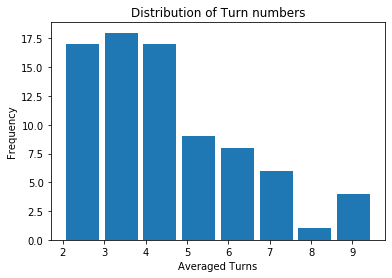

In [12]:
plt.hist(x=df_con2['averaged_turn'], bins='auto', rwidth=0.85);
plt.xlabel('Averaged Turns');
plt.ylabel('Frequency');
plt.title('Distribution of Turn numbers');

Averaged turn number for the whole corpora

In [13]:
np.mean(df_con2['averaged_turn'])

4.4625

#### Organize DataFrame for each Turn

* Utterance of each turn is a single row:

In [14]:
#For each round 
index_all_A,condition_all_A,pair_all_A,topic_all_A,turn_txt_A_all,round_A_all,inter_A_all,time_A_all=[],[],[],[],[],[],[],[]
index_all_B,condition_all_B,pair_all_B,topic_all_B,turn_txt_B_all,round_B_all,inter_B_all,time_B_all=[],[],[],[],[],[],[],[]

for index, row in df_con2.iterrows():
    index0=index
    condition0=row['condition']
    pair0=row['pair_id']
    topic0=row['topic']
    turn_A=len(row['round_A'])
    turn_B=len(row['round_B'])
    time_A=row['time_A']
    time_B=row['time_B']
    
    index_all_A.extend([index0]*turn_A)
    pair_all_A.extend([pair0]*turn_A)
    topic_all_A.extend([topic0]*turn_A)
    condition_all_A.extend([condition0]*turn_A)
    time_A_all.extend(time_A)
    time_B_all.extend(time_B)
    turn_txt_A=row['turn_txt_A']
    turn_txt_A_all.extend(turn_txt_A[:turn_A])
    round_A_all.extend(row['round_A'])
    inter_A=row['inter_num_A']
    if len(inter_A)<turn_A:
        inter_A.extend([0]*(turn_A-len(inter_A)))
    inter_A_all.extend(inter_A[:turn_A])
    
    index_all_B.extend([index0]*turn_B)
    pair_all_B.extend([pair0]*turn_B)
    topic_all_B.extend([topic0]*turn_B)
    condition_all_B.extend([condition0]*turn_B)
    turn_txt_B=row['turn_txt_B']
    turn_txt_B_all.extend(turn_txt_B[:turn_B])
    #turn_txt_B_all.extend(row['turn_txt_B'])
    round_B_all.extend(row['round_B'])
    inter_B=row['inter_num_B']
    if len(inter_B)<turn_B:
        inter_B.extend([0]*(turn_B-len(inter_B)))
    inter_B_all.extend(inter_B[:turn_B])
    #inter_B_all.extend(row['inter_num_B'][:turn_B])
    
df_A=pandas.DataFrame({'index':index_all_A,'condition':condition_all_A,'pair_id':pair_all_A,'topic':topic_all_A,'turn_txt':turn_txt_A_all,'round':round_A_all,'time':time_A_all,'inter_num':inter_A_all})
df_B=pandas.DataFrame({'index':index_all_B,'condition':condition_all_B,'pair_id':pair_all_B,'topic':topic_all_B,'turn_txt':turn_txt_B_all,'round':round_B_all,'time':time_B_all,'inter_num':inter_B_all})

In [15]:
import lucem_illud_2020
df_A['tokenized_text'] = df_A['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_A['word_counts'] = df_A['tokenized_text'].apply(lambda x: len(x))
df_B['tokenized_text'] = df_B['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_B['word_counts'] = df_B['tokenized_text'].apply(lambda x: len(x))

In [16]:
df_A['agent']=['A']*len(df_A)
df_B['agent']=['B']*len(df_B)

In [17]:
df_AB_turn=pandas.concat([df_A,df_B])
df_AB_turn=df_AB_turn.reset_index(drop=True)
df_AB_turn

,index,condition,pair_id,topic,turn_txt,round,time,inter_num,tokenized_text,word_counts,agent
0,0,NB,5,11,"Yeah, like definitely, like, I definitely see ...",1,43,0,"[Yeah, like, definitely, like, I, definitely, ...",229,A
1,0,NB,5,11,And then the other thing is like from like a m...,2,104,0,"[And, then, the, other, thing, is, like, from,...",169,A
2,1,TYB,6,2,"Oh really, Okay, uhhm so I-I think the reason ...",1,0,0,"[Oh, really, Okay, uhhm, so, I, I, think, the,...",88,A
3,1,TYB,6,2,"Yeah, I know. I totally agree with the practic...",2,58,0,"[Yeah, I, know, I, totally, agree, with, the, ...",51,A
4,1,TYB,6,2,. Uh-huh. . There might be like some cost to d...,3,88,0,"[Uh, huh, There, might, be, like, some, cost, ...",69,A
...,...,...,...,...,...,...,...,...,...,...,...
709,79,TYB,108,15,yeah. oh. Yeah. that makes sense. Yeah. Right...,2,54,0,"[yeah, oh, Yeah, that, makes, sense, Yeah, Rig...",32,B
710,79,TYB,108,15,"Oh, are you saying that, are you saying that. ...",3,63,3,"[Oh, are, you, saying, that, are, you, saying,...",39,B
711,79,TYB,108,15,yeah. oh. really. Test on human. that makes s...,4,103,0,"[yeah, oh, really, Test, on, human, that, make...",49,B
712,79,TYB,108,15,"That' s so funny. I just popped in like, what ...",5,123,2,"[That, s, so, funny, I, just, popped, in, like...",16,B


##### Time label
Tag time label for each turn, acorrding to timestamp; divide into 7 intervals: 

    Tag 1: <30s; Tag 2: 30-60s; Tag 3: 60-90s; Tag 4: 90-120s; Tag 5: 120-150s; Tag 6: 150-180s; Tag 7: >180s

In [18]:
def time_label(x):
    if x<30:
        return int(1)
    elif x<60:
        return int(2)
    elif x<90:
        return int(3)
    elif x<120:
        return int(4)
    elif x<150:
        return int(5)
    elif x<180:
        return int(6)
    else:
        return int(7)

In [19]:
df_AB_turn['time_label']=df_AB_turn['time'].apply(lambda x: time_label(x))

In [20]:
time_label_countPcate=df_AB_turn.groupby('time_label').count()['index']

Number of Turns under each time label(interval):

In [21]:
time_label_countPcate

time_label
1    147
2    101
3     96
4    107
5    144
6    117
7      2
Name: index, dtype: int64

##### Tag Turn Label:

Tag turn label, according to their positions in the conversation, divide into 3 parts: 
    for example, for a 3 turns conversation: tag turn1 as 1, turn2 as 2, turn3 as 3.
    for a 5 turns conversation: tag turn1/2 as 1, turn3/4 as 2, turn5 as 3.


In [22]:
turn_label_all=[]
for index, row in df_AB_turn.iterrows(): 
    agent=row['agent']
    pair_id=row['pair_id']
    current_r=row['round']
    turn_A_num=len(df_con2[df_con2['pair_id']==pair_id]['round_A'].values[0])
    turn_B_num=len(df_con2[df_con2['pair_id']==pair_id]['round_B'].values[0])
    turn_len=min(turn_A_num,turn_B_num)
    
    if turn_len==2:
        if current_r==1:
            turn_label_all.append(1)
        else:
            turn_label_all.append(2)
    elif turn_len==3:
        if current_r==1:
            turn_label_all.append(1)
        elif current_r==2:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)
    elif turn_len==4:
        if current_r==1:
            turn_label_all.append(1)
        elif current_r in [2,3]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)            
    elif turn_len==5 or turn_len==6:
        if current_r in [1,2]:
            turn_label_all.append(1)
        elif current_r in [3,4]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)       
    elif turn_len==7:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)   
    elif turn_len==8 or turn_len==9:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5,6]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)  
    elif turn_len==10:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5,6,7]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3) 
    elif turn_len==1:
        if current_r==1:
            turn_label_all.append(1)
        else:
            turn_label_all.append(2)

In [23]:
df_AB_turn['turn_label']=turn_label_all

Number of Turns under each turn label:

In [24]:
turn_label_countPcate=df_AB_turn.groupby('turn_label').count()['index']
turn_label_countPcate

turn_label
1    238
2    272
3    204
Name: index, dtype: int64

#### Organize for each Agent:

* Each agent (A/B) is a single row:

In [25]:
#extract corpora of each speaker and organize into one list/dataframe
A_cop=[]
A_con=[]
A_topic=[]
for index, row in df_con2.iterrows():
    A_cop.append(row['con_txt_A'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_A'])
    A_cop.append(row['con_txt_B'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_B'])

In [26]:
label=[]
for i in range(len(df_con2)):
    label.append('A_'+str(i+1))
    label.append('B_'+str(i+1))

In [27]:
df_AB=pandas.DataFrame({'con_txt':A_cop,'condition':A_con,'label':label,'topic':A_topic})

In [28]:
def get_agent(labelab):
    agent=labelab[0]
    return agent
df_AB['agent']=df_AB['label'].apply(lambda x: get_agent(x))
df_AB.head()

,con_txt,condition,label,topic,agent
0,"Yeah, like definitely, like, I definitely see ...",NB,A_1,11,A
1,I actually didn't look much into the legal sys...,NB,B_1,11,B
2,"Oh really, Okay, uhhm so I-I think the reason ...",TYB,A_2,2,A
3,I think I really like your concern about the n...,TYB,B_2,2,B
4,"So I, when I read this question I thought abou...",NB,A_3,5,A


### Part 1 Linguistic Feature Analysis

Analysis Plan:
1. Define and Extract Features (Negation, appreciation, affirmation, agreement..)
   1. 8 our self defined (appreciation, affirmation, assent, agreement, laugh, fillpause, youknow, i don't know) 
   2. 9 feature categories from LIWC (conjunction, negate, postive emotion, negative emotion, certainty and so on.)
2. Derive LIWC category scores & Log-transformed counts of self defined features

3. Show feature score/counts difference by conditions and agent

4. Build Regression model to predict 6 behavior measures by linguistic features
    1. 3 models are built, predicted by features of one's own/partner's/averaged corpora 
    2. use ridge and lasso regression
    3. report and visualize both MSE, coefficients of each model

In [29]:
df_AB_turn2=df_AB_turn

Extract self defined features: 
  1. search token by token for targeted lexion of each feature
  2. use regular expression to extract targeted expression (e.g. 'i like')

In [30]:
#version2
app_count_all,aff_count_all,ass_count_all,agg_count_all,filpau_count_all,laugh_count_all=[],[],[],[],[],[]
yknow_count_all,idknow_count_all=[],[]
#ilike_count_all=[]

#linguistic feature list
app_list=['appreciate','thank','thanks']
aff_list=['mm', 'mmm', 'mm-hmm', 'mhmm', 'mhm', 'mmhm','mm-hm','uh-huh','uh-uh','uhh-huh','oh','ok','okay']
ass_list=['ya','yes','yea','yeah','yep','right','sure','gotcha']  #i see
agg_list=['agree'] #I like, make sense
filpau_list=['hmm','hm','um','umm','ummm','er','uhh','uh','huhh']
laugh_list=['laugh','laughs', 'laughing','haha']
#you know
#I don't know

for index, row in df_AB_turn2.iterrows():  #[df_AB_turn2['pair_id']==5]
    text=row['tokenized_text']
    app_count,aff_count,ass_count,agg_count,filpau_count,laugh_count,yknow_count,idknow_count=0,0,0,0,0,0,0,0
    #ilike_count=0

    line=row['turn_txt']
    #affirmation
    re_aff=r'mm-hmm'
    find_aff=re.findall(re_aff,line.lower())
    for other in find_aff:
        aff_count+=1
        #print(other,'aff')
    line=re.sub(re_aff,'', line)
    
    re_aff=r'mm-hm'
    find_aff=re.findall(re_aff,line.lower())
    for other in find_aff:
        aff_count+=1
        #print(other,'aff')
    line=re.sub(re_aff,'', line)
    
    re_aff=r'uh-huh'
    find_aff=re.findall(re_aff,line.lower())
    for other in find_aff:
        aff_count+=1
        #print(other,'aff')
    line=re.sub(re_aff,'', line)

    re_aff=r'uh-uh'
    find_aff=re.findall(re_aff,line.lower())
    for other in find_aff:
        aff_count+=1
        #print(other,'aff')
    line=re.sub(re_aff,'', line)
    
    re_aff=r'uhh-huh'
    find_aff=re.findall(re_aff,line.lower())
    for other in find_aff:
        aff_count+=1
        #print(other,'aff')
    line=re.sub(re_aff,'', line)
    
    for word in text[:30]:   #appreciation, affirmation, assent only count those words in the beginning
        word=word.lower()
        if word in app_list:
            app_count+=1
            #print(word,'app')
        if word in aff_list:
            aff_count+=1
            #print(word,'aff')
        if word in ass_list:
            ass_count+=1
            #print(word,'ass')
        
    for word in text:
        word=word.lower()
        if word in agg_list:
            agg_count+=1  
            #print(word,'agg')
        if word in filpau_list:
            filpau_count+=1
            #print(word,'filpau')
        if word in laugh_list:
            laugh_count+=1
            #print(word,'laugh')
    
    #I see
    re_isee0=r'i see'
    re_isee1=r'i (\S*?) see'
    find_isee0=re.findall(re_isee0,line.lower())
    find_isee1=re.findall(re_isee1,line.lower())
    for other in find_isee0:
        ass_count+=1
        #print(line,other)
    for other in find_isee1:
        if other not in ["don't","also"]:
            ass_count+=1
        #else:
            #print(line,other)
        
    #I like
    re_ilike0=r'i like that'
    re_ilike1=r'i really like'
    find_ilike0=re.findall(re_ilike0,line.lower())
    find_ilike1=re.findall(re_ilike1,line.lower())
    for other in find_ilike0:
        agg_count+=1
        #print(line,other)
    for other in find_ilike1:
        agg_count+=1
        #print(line,other)

    #make sense
    re_ms=r'make sense'
    find_ms=re.findall(re_ms,line.lower())
    for other in find_ms:
        agg_count+=1
        #print(other)

    #you know
    re_yk=r'you know'
    find_yk=re.findall(re_yk,line.lower())
    for other in find_yk:
        yknow_count+=1
        #print(other)
        
    #i don't know
    re_idk=r"i don't know"
    find_idk=re.findall(re_idk,line.lower())
    for other in find_idk:
        idknow_count+=1
        #print(other)
        
    app_count_all.append(app_count)
    aff_count_all.append(aff_count)
    ass_count_all.append(ass_count)
    agg_count_all.append(agg_count)
    filpau_count_all.append(filpau_count)
    laugh_count_all.append(laugh_count)
    idknow_count_all.append(idknow_count)
    yknow_count_all.append(yknow_count)
    #ilike_count_all.append(ilike_count)

#store the count info of each feature 
df_AB_turn2['appre_c']=app_count_all
df_AB_turn2['affir_c']=aff_count_all
df_AB_turn2['assent_c']=ass_count_all
df_AB_turn2['aggree_c']=agg_count_all
df_AB_turn2['fillpause_c']=filpau_count_all
df_AB_turn2['laugh_c']=laugh_count_all 
df_AB_turn2['yknow_c']=yknow_count_all
df_AB_turn2['idknow_c']=idknow_count_all        

In [31]:
df_con2['pair_id']=df_con2['pair_id'].apply(lambda x: int(x))
df_AB_turn2['pair_id']=df_AB_turn2['pair_id'].apply(lambda x: int(x))

In [32]:
df_AB_turn['pair_id']=df_AB_turn['pair_id'].apply(lambda x: int(x))

Aggregate feature counts at agent and conversation level:

In [35]:
df=df_AB_turn2['appre_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['appre_c']=df.values
df=df_AB_turn2['affir_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['affir_c']=df.values
df=df_AB_turn2['assent_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['assent_c']=df.values
df=df_AB_turn2['aggree_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['aggree_c']=df.values
df=df_AB_turn2['fillpause_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['fillpause_c']=df.values
df=df_AB_turn2['laugh_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['laugh_c']=df.values
df=df_AB_turn2['yknow_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['yknow_c']=df.values
df=df_AB_turn2['idknow_c'].groupby(df_AB_turn2['pair_id']).sum()
df_con2['idknow_c']=df.values

In [36]:
df=df_AB_turn2['appre_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['appre_c']=df.values
df=df_AB_turn2['affir_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['affir_c']=df.values
df=df_AB_turn2['assent_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['assent_c']=df.values
df=df_AB_turn2['aggree_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['aggree_c']=df.values
df=df_AB_turn2['fillpause_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['fillpause_c']=df.values
df=df_AB_turn2['laugh_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['laugh_c']=df.values
df=df_AB_turn2['yknow_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['yknow_c']=df.values
df=df_AB_turn2['idknow_c'].groupby([df_AB_turn2['pair_id'],df_AB_turn2['agent']]).sum()
df_AB['idknow_c']=df.values

Show feature counts for each conversation:

In [37]:
df_con2.head()

,condition,pair_id,topic,conversation_txt,con_txt_A,con_txt_B,turn_txt_A,turn_txt_B,round_A,round_B,...,last_turn1_B,averaged_turn,appre_c,affir_c,assent_c,aggree_c,fillpause_c,laugh_c,yknow_c,idknow_c
0,NB,5,11,I actually didn't look much into the legal sys...,"Yeah, like definitely, like, I definitely see ...",I actually didn't look much into the legal sys...,"[Yeah, like definitely, like, I definitely see...",[I actually didn't look much into the legal sy...,"[1, 2]","[1, 2, 3]",...,3,2.5,0,0,3,0,6,0,10,2
1,TYB,6,2,"Oh really, Okay, uhhm so I-I think the reason ...","Oh really, Okay, uhhm so I-I think the reason ...",I think I really like your concern about the n...,"[Oh really, Okay, uhhm so I-I think the reason...",[I think I really like your concern about the ...,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",...,6,6.0,0,7,11,5,10,2,1,3
2,NB,7,5,"So I, when I read this question I thought abou...","So I, when I read this question I thought abou...","So, uh I-I actually uh read a lot about this t...","[So I, when I read this question I thought abo...","[So, uh I-I actually uh read a lot about this ...","[1, 2, 3, 4]","[1, 2, 3]",...,3,3.5,0,3,0,0,28,0,0,2
3,TYB,8,7,"Oh wow Okay, well, I give it an eight so..I me...","Oh wow Okay, well, I give it an eight so..I me...","Okay I see where you're coming, but from in te...","[Oh wow Okay, well, I give it an eight so..I m...","[Okay I see where you're coming, but from in t...","[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7]",...,7,7.5,0,4,14,0,2,2,0,2
4,TYB,11,9,I just strongly believe in the right to um {{}...,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,[I just strongly believe in the right to um {{...,[I like what you said about like the right to....,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5]",...,5,5.5,0,2,11,3,10,4,1,4


Show feature counts for each agent in the conversation:

In [38]:
df_AB_turn.head()

,index,condition,pair_id,topic,turn_txt,round,time,inter_num,tokenized_text,word_counts,...,time_label,turn_label,appre_c,affir_c,assent_c,aggree_c,fillpause_c,laugh_c,yknow_c,idknow_c
0,0,NB,5,11,"Yeah, like definitely, like, I definitely see ...",1,43,0,"[Yeah, like, definitely, like, I, definitely, ...",229,...,2,1,0,0,2,0,2,0,5,1
1,0,NB,5,11,And then the other thing is like from like a m...,2,104,0,"[And, then, the, other, thing, is, like, from,...",169,...,4,2,0,0,0,0,1,0,5,0
2,1,TYB,6,2,"Oh really, Okay, uhhm so I-I think the reason ...",1,0,0,"[Oh, really, Okay, uhhm, so, I, I, think, the,...",88,...,1,1,0,2,0,0,3,0,1,0
3,1,TYB,6,2,"Yeah, I know. I totally agree with the practic...",2,58,0,"[Yeah, I, know, I, totally, agree, with, the, ...",51,...,2,1,0,1,2,1,0,0,0,0
4,1,TYB,6,2,. Uh-huh. . There might be like some cost to d...,3,88,0,"[Uh, huh, There, might, be, like, some, cost, ...",69,...,3,2,0,1,0,0,1,0,0,0


####  Extract LIWC features and Aggregate Features

with LIWC

In [39]:
import pandas as pd
import math

Log transformed self-defined feature counts:

In [40]:
def log_trans(x):
    if x>0:
        x=math.log(x)
    return x

In [41]:
df_AB['appre_log']=df_AB['appre_c'].apply(lambda x: log_trans(x))
df_AB['affir_log']=df_AB['affir_c'].apply(lambda x: log_trans(x))
df_AB['assent_log']=df_AB['assent_c'].apply(lambda x: log_trans(x))
df_AB['aggree_log']=df_AB['aggree_c'].apply(lambda x: log_trans(x))
df_AB['fillpause_log']=df_AB['fillpause_c'].apply(lambda x: log_trans(x))
df_AB['laugh_log']=df_AB['laugh_c'].apply(lambda x: log_trans(x))
df_AB['yknow_log']=df_AB['yknow_c'].apply(lambda x: log_trans(x))
df_AB['idknow_log']=df_AB['idknow_c'].apply(lambda x: log_trans(x))

In [42]:
df_con2['appre_log']=df_con2['appre_c'].apply(lambda x: log_trans(x))
df_con2['affir_log']=df_con2['affir_c'].apply(lambda x: log_trans(x))
df_con2['assent_log']=df_con2['assent_c'].apply(lambda x: log_trans(x))
df_con2['aggree_log']=df_con2['aggree_c'].apply(lambda x: log_trans(x))
df_con2['fillpause_log']=df_con2['fillpause_c'].apply(lambda x: log_trans(x))
df_con2['laugh_log']=df_con2['laugh_c'].apply(lambda x: log_trans(x))
df_con2['yknow_log']=df_con2['yknow_c'].apply(lambda x: log_trans(x))
df_con2['idknow_log']=df_con2['idknow_c'].apply(lambda x: log_trans(x))

In [43]:
df_AB_turn2['appre_log']=df_AB_turn2['appre_c'].apply(lambda x: log_trans(x))
df_AB_turn2['affir_log']=df_AB_turn2['affir_c'].apply(lambda x: log_trans(x))
df_AB_turn2['assent_log']=df_AB_turn2['assent_c'].apply(lambda x: log_trans(x))
df_AB_turn2['aggree_log']=df_AB_turn2['aggree_c'].apply(lambda x: log_trans(x))
df_AB_turn2['fillpause_log']=df_AB_turn2['fillpause_c'].apply(lambda x: log_trans(x))
df_AB_turn2['laugh_log']=df_AB_turn2['laugh_c'].apply(lambda x: log_trans(x))
df_AB_turn2['yknow_log']=df_AB_turn2['yknow_c'].apply(lambda x: log_trans(x))
df_AB_turn2['idknow_log']=df_AB_turn2['idknow_c'].apply(lambda x: log_trans(x))

Save self-defined features into csv to be merged with LIWC features:

In [36]:
df_AB.to_csv('ab_corpora_withfeature.csv')

In [37]:
df_con2.to_csv('con_corpora_withfeature.csv')

In [37]:
df_AB_turn2.to_csv('con_corpora_withfeature.csv')

LIWC features are calculated using a LIWC2015 software and aggregated in excel, import the aggregated excel:

In [44]:
df_con2F=pd.read_csv('con_corpora_onlyfeature.csv') 
df_abF=pd.read_csv('ab_corpora_onlyfeature.csv') 

In [45]:
df_turnF=pd.read_csv('turn_corpora_onlyfeature.csv') 

In [46]:
#aggregate
np_con2features=df_con2F.values
np_abfeatures=df_abF.values
np_turnfeatures=df_turnF.values

In [49]:
np_turnfeatures.shape

(714, 17)

Because there are both 'assent' features both self-defined and LIWC features, so we calculated the correlation score between these two features: 
* the level of correlation is moderate around 0.64

In [50]:
np.corrcoef(df_con2F['assent_log'],df_con2F['assent'])

array([[1.        , 0.63670588],
       [0.63670588, 1.        ]])

In [51]:
np.corrcoef(df_abF['assent_log'],df_abF['assent'])

array([[1.        , 0.65407906],
       [0.65407906, 1.        ]])

#### Build Regression Model

Build regression model based on linguistic features, to predict behavior measures at agent/conversation level:

Import behavior measure scores in 3 format:
* utterance of each person linked with their own behavior measure scores
* utterance of each person linked with their partners' behavior measure scores
* utterance of each person linked with their averaged behavior measure scores

In [52]:
df_score_ab=pd.read_csv('TYB_annotation_ab.csv') 
df_score_ba=pd.read_csv('TYB_annotation_ba.csv') 
df_score_all=pd.read_csv('TYB_annotation_all.csv') 

In [54]:
#derive score for each behavior measure
np_x1_all=df_score_all['X1_feel_collaborative'].values
np_x2_all=df_score_all['X2_feel_heard'].values
np_x3_all=df_score_all['X3_hearing_other'].values
np_x4_all=df_score_all['X4_common_ground'].values
np_x5_all=df_score_all['X5_reasonable'].values
np_x6_all=df_score_all['X6_warm'].values

In [58]:
#define list to store model results, for ridge regression
MSE_by_oneself,MSE_by_partner,MSE_by_averaged=[],[],[]
coeff_oneself,coeff_partner,coeff_averaged=[],[],[]
variable_name=['X1_feel_collaborative','X2_feel_heard','X3_hearing_other','X4_common_ground','X5_reasonable','X6_warm']

In [74]:
#define list to store model results, for lasso regression
MSE_by_oneself_l,MSE_by_partner_l,MSE_by_averaged_l=[],[],[]
coeff_oneself_l,coeff_partner_l,coeff_averaged_l=[],[],[]

Build **Ridge Regression Model**, report and visualize MSE and coefficient scores:

a. predict averaged behavior measures by features from the whole corpora

In [71]:
#generate ridge regression model 
from sklearn.linear_model import Ridge,RidgeCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
ridge_cv = RidgeCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
ridge_cv.fit(np_con2features,np_x6_all) 
ridge_p_beta=ridge_cv.coef_
ridge_best_alpha = ridge_cv.alpha_

#report and sort the coefficients in Ridge:
ridge_p_beta0=[(i,p) for i,p in enumerate(ridge_p_beta)]
def by_score(t):
    return -t[1]
ridge_p_beta0= sorted(ridge_p_beta0, key=by_score)

#predict Y based on test dataset
p_Y=ridge_cv.predict(np_con2features)
ridge_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_all-p_Y).reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
ridge_MSE=model_MSE

In [72]:
#save the results
MSE_by_averaged.append(model_MSE)
coeff_averaged.append(ridge_p_beta)

In [73]:
print('Ridge Test MSE:',round(model_MSE,4))
print('Ridge best Alpha/Lamnda:',round(ridge_best_alpha,4))
print('Ridge Coefficicents:',ridge_p_beta0)

Ridge Test MSE: 5.7045
Ridge best Alpha/Lamnda: 2.848
Ridge Coefficicents: [(3, 0.46017554179321135), (0, 0.19762690535161953), (7, 0.14568370104567543), (2, 0.1107449160841297), (5, 0.10663823974507547), (15, 0.08641039941198914), (8, 0.08507218383828237), (1, 0.07425642789076488), (16, 0.0691399224168965), (10, 0.04490792559882933), (6, 0.03387977069036355), (4, 0.03307574686848976), (12, 0.010152912265103375), (9, 0.008008696300193267), (14, 0.0021791508036415963), (11, -0.027407586477715982), (13, -0.05585979464373467)]


Lasso Regression:

In [85]:
#generate lasso regression model 
from sklearn.linear_model import Lasso,LassoCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
lasso_cv.fit(np_con2features,np_x6_all) 
lasso_p_beta=lasso_cv.coef_
lasso_best_alpha = lasso_cv.alpha_

#find the non-zero coefficients in Lasso:
lasso_p_beta0=[(i,p) for i,p in enumerate(lasso_p_beta) if p>0]

#predict Y based on test dataset
p_Y=lasso_cv.predict(np_con2features)
lasso_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_all-p_Y)#.reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
lasso_MSE=model_MSE

In [86]:
#save the results
MSE_by_averaged_l.append(model_MSE)
coeff_averaged_l.append(lasso_p_beta0)

In [87]:
print('Lasso MSE:',round(model_MSE,4))
print('Lasso best Alpha/Lamnda:',round(lasso_best_alpha,4))
print('Lasso Num of Non-zero Coefficicents:',len(lasso_p_beta0))
print('Lasso Coefficicents:',lasso_p_beta0)

Lasso MSE: 6.0222
Lasso best Alpha/Lamnda: 0.0689
Lasso Num of Non-zero Coefficicents: 1
Lasso Coefficicents: [(3, 0.8435672837889643)]


b. predict **one's behavior measures** by **features** from their **own corpora**:

In [88]:
np_x1_ab=df_score_ab['X1_feel_collaborative'].values
np_x2_ab=df_score_ab['X2_feel_heard'].values
np_x3_ab=df_score_ab['X3_hearing_other'].values
np_x4_ab=df_score_ab['X4_common_ground'].values
np_x5_ab=df_score_ab['X5_reasonable'].values
np_x6_ab=df_score_ab['X6_warm'].values

In [101]:
#generate ridge regression model 
from sklearn.linear_model import Ridge,RidgeCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
ridge_cv = RidgeCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
ridge_cv.fit(np_abfeatures,np_x6_ab) 
ridge_p_beta=ridge_cv.coef_
ridge_best_alpha = ridge_cv.alpha_

#report and sort the coefficients in Ridge:
ridge_p_beta0=[(i,p) for i,p in enumerate(ridge_p_beta)]
def by_score(t):
    return -t[1]
ridge_p_beta0= sorted(ridge_p_beta0, key=by_score)

#predict Y based on test dataset
p_Y=ridge_cv.predict(np_abfeatures)
ridge_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_ab-p_Y).reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
ridge_MSE=model_MSE

In [102]:
#save the results
MSE_by_oneself.append(model_MSE)
coeff_oneself.append(ridge_p_beta)

In [103]:
print('Ridge Test MSE:',round(model_MSE,4))
print('Ridge best Alpha/Lamnda:',round(ridge_best_alpha,4))
print('Ridge Coefficicents:',ridge_p_beta0)

Ridge Test MSE: 3.1192
Ridge best Alpha/Lamnda: 14.5083
Ridge Coefficicents: [(3, 0.04355680182655593), (2, 0.021685420142470078), (6, 0.019504199090106273), (5, 0.013868029518277035), (4, 0.011872916634393079), (8, 0.009120129512549017), (9, 0.008641452802522187), (15, 0.007708772925103112), (16, 0.006460171322641855), (10, 0.0034763871207224664), (7, 0.002345508145071222), (14, 0.0006151270868088542), (1, -0.00014999179276980597), (13, -0.0033691180525990644), (12, -0.003873417257724964), (11, -0.007455984451353826), (0, -0.01977834371615251)]


Lasso Regression: 

In [114]:
#generate lasso regression model 
from sklearn.linear_model import Lasso,LassoCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
lasso_cv.fit(np_abfeatures,np_x6_ab) 
lasso_p_beta=lasso_cv.coef_
lasso_best_alpha = lasso_cv.alpha_

#find the non-zero coefficients in Lasso:
lasso_p_beta0=[(i,p) for i,p in enumerate(lasso_p_beta) if p>0]

#predict Y based on test dataset
p_Y=lasso_cv.predict(np_abfeatures)
lasso_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_ab-p_Y)#.reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
lasso_MSE=model_MSE

In [115]:
#save the results
MSE_by_oneself_l.append(model_MSE)
coeff_oneself_l.append(lasso_p_beta0)

In [116]:
print('Lasso MSE:',round(model_MSE,4))
print('Lasso best Alpha/Lamnda:',round(lasso_best_alpha,4))
print('Lasso Num of Non-zero Coefficicents:',len(lasso_p_beta0))
print('Lasso Coefficicents:',lasso_p_beta0)

Lasso MSE: 3.1748
Lasso best Alpha/Lamnda: 100000.0
Lasso Num of Non-zero Coefficicents: 0
Lasso Coefficicents: []


c. predict **one's behavior measures** by **features** from their **partner's corpora**:

In [118]:
#import behavior measures
np_x1_ba=df_score_ba['X1_feel_collaborative'].values
np_x2_ba=df_score_ba['X2_feel_heard'].values
np_x3_ba=df_score_ba['X3_hearing_other'].values
np_x4_ba=df_score_ba['X4_common_ground'].values
np_x5_ba=df_score_ba['X5_reasonable'].values
np_x6_ba=df_score_ba['X6_warm'].values

In [131]:
#generate ridge regression model 
from sklearn.linear_model import Ridge,RidgeCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
ridge_cv = RidgeCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
ridge_cv.fit(np_abfeatures,np_x6_ba) 
ridge_p_beta=ridge_cv.coef_
ridge_best_alpha = ridge_cv.alpha_

#report and sort the coefficients in Ridge:
ridge_p_beta0=[(i,p) for i,p in enumerate(ridge_p_beta)]
def by_score(t):
    return -t[1]
ridge_p_beta0= sorted(ridge_p_beta0, key=by_score)

#predict Y based on test dataset
p_Y=ridge_cv.predict(np_abfeatures)
ridge_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_ba-p_Y).reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
ridge_MSE=model_MSE

In [132]:
#save the results
MSE_by_partner.append(model_MSE)
coeff_partner.append(ridge_p_beta)

In [133]:
print('Ridge Test MSE:',round(model_MSE,4))
print('Ridge best Alpha/Lamnda:',round(ridge_best_alpha,4))
print('Ridge Coefficicents:',ridge_p_beta0)

Ridge Test MSE: 2.9479
Ridge best Alpha/Lamnda: 2.848
Ridge Coefficicents: [(3, 0.2733348662210484), (5, 0.12721868238466463), (7, 0.08628084406823222), (2, 0.06263064067664584), (10, 0.02650715903075901), (8, 0.022771758834305596), (16, 0.02202433502398351), (6, 0.02030775945113017), (1, 0.018423730949797833), (0, 0.017038585497892424), (15, 0.01676430053808333), (11, 0.010594201208750674), (12, 0.00861128942709661), (4, -0.0075656277321984305), (13, -0.0077520656323379275), (14, -0.0142648477753545), (9, -0.034059900547387986)]


In [145]:
#generate lasso regression model 
from sklearn.linear_model import Lasso,LassoCV
alphas=np.logspace(-5, 5, 100)  #set a range of lammda
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 10)  #10-cross validation
lasso_cv.fit(np_abfeatures,np_x6_ba) 
lasso_p_beta=lasso_cv.coef_
lasso_best_alpha = lasso_cv.alpha_

#find the non-zero coefficients in Lasso:
lasso_p_beta0=[(i,p) for i,p in enumerate(lasso_p_beta) if p>0]

#predict Y based on test dataset
p_Y=lasso_cv.predict(np_abfeatures)
lasso_p_Y=p_Y

#calculate MSE
y_diff=(np_x6_ba-p_Y)#.reshape(p_Y.shape[0])
model_MSE=np.dot(y_diff,y_diff)/y_diff.shape[0]
lasso_MSE=model_MSE

In [146]:
#save the results
MSE_by_partner_l.append(model_MSE)
coeff_partner_l.append(lasso_p_beta0)

In [147]:
print('Lasso MSE:',round(model_MSE,4))
print('Lasso best Alpha/Lamnda:',round(lasso_best_alpha,4))
print('Lasso Num of Non-zero Coefficicents:',len(lasso_p_beta0))
print('Lasso Coefficicents:',lasso_p_beta0)

Lasso MSE: 2.9807
Lasso best Alpha/Lamnda: 0.0171
Lasso Num of Non-zero Coefficicents: 4
Lasso Coefficicents: [(2, 0.03212961412275886), (3, 0.5199852543044333), (5, 0.18882974021469062), (16, 0.0018006737739533524)]


##### Visualization the MSE results:

MSE of ridge regression, 3 models for 6 dependent variables:

In [148]:
df_MSE=pd.DataFrame({'oneself':MSE_by_oneself,'partner':MSE_by_partner,'averaged':MSE_by_averaged},index=variable_name)

In [149]:
df_MSE

,oneself,partner,averaged
X1_feel_collaborative,3.928856,3.946680,10.094927
X2_feel_heard,2.668970,2.391356,4.855952
X3_hearing_other,1.948868,1.812962,3.894949
X4_common_ground,2.980057,2.922069,7.180572
X5_reasonable,2.393355,2.382714,4.868969
X6_warm,3.119162,2.947871,5.704470


From the table above and below of MSE, we could see that: 1) the results of Lasso and Ridge regression is very close to each other; 2) generally, predicted behavior measures by features from **'partner'** yields the best fit; 3) variable `Hearing other` is best predicted and fit among all variables.  

MSE of lasso regression, 3 models for 6 dependent variables:

In [161]:
df_MSE_l=pd.DataFrame({'oneself':MSE_by_oneself_l,'partner':MSE_by_partner_l,'averaged':MSE_by_averaged_l},index=variable_name)

In [162]:
df_MSE_l

,oneself,partner,averaged
X1_feel_collaborative,4.053432,3.880752,9.683987
X2_feel_heard,2.740586,2.371632,4.902237
X3_hearing_other,1.948872,1.873248,3.838734
X4_common_ground,3.003896,3.039834,7.545539
X5_reasonable,2.509336,2.350169,4.531693
X6_warm,3.174844,2.980676,6.022164


##### Visualization of the Coefficient results:

Detailed explanation of the results please see in the report

In [164]:
variable_name

['X1_feel_collaborative',
 'X2_feel_heard',
 'X3_hearing_other',
 'X4_common_ground',
 'X5_reasonable',
 'X6_warm']

In [163]:
all_feature_label=['appreciation_log','affirmation_log','assent_log', 'agreement_log','fillpause_log','laugh_log','yknow_log','idknow_log','conj_liwc','negate_liwc','posemo_liwc','negemo_liwc','insight_liwc','cause_liwc','discrep_liwc','certain_liwc','assent_liwc']

In [185]:
#visulize coeffifient,sorted & unsorted
def visualize_coeff(var,model3,description,sort=1):
    ridge_p_beta=model3[var]
    ridge_p_beta0=[(x,y) for x,y in enumerate(ridge_p_beta.tolist())]
    if sort==1:
        ridge_p_beta1= sorted(ridge_p_beta0, key=by_score,reverse=True)
    else:
        ridge_p_beta1=ridge_p_beta0
    
    plt.figure(figsize=(5,8))
    value=[y for (x,y) in ridge_p_beta1]
    labels=[all_feature_label[x] for (x,y) in ridge_p_beta1]
    x_pos=np.arange(len(labels))
    bar_width=0.8

    my_color=np.where(np.array(value)>=0, 'navy', 'cornflowerblue')
    plt.barh(x_pos,value,color=my_color,alpha=0.8);

    plt.yticks(x_pos,labels) #,FontSize=8)
    plt.grid(True);
    plt.grid(linestyle='--', linewidth=1,alpha=0.3)
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #for i in range(len(x_pos)):
    #    plt.text(x=0.35 , y =  x_pos[i], s = round(value[i],3), size = 12)

    title_name="Coefficients by Ridge"+' '+description
    #plt.title("Coefficients by Ridge (Collaborative)-the other");
    plt.title(title_name);
    plt.xlabel('coefficent value');
    plt.ylabel('Feature');

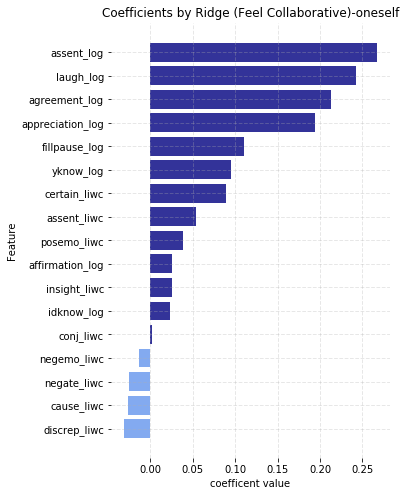

In [186]:
#collaborative sorted, oneself
visualize_coeff(0,coeff_oneself,'(Feel Collaborative)-oneself')

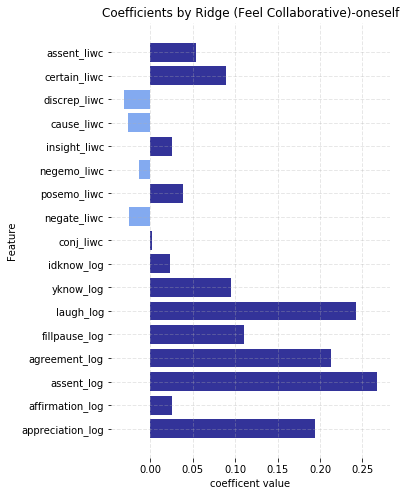

In [187]:
#collaborative unsorted, oneself
visualize_coeff(0,coeff_oneself,'(Feel Collaborative)-oneself',0)

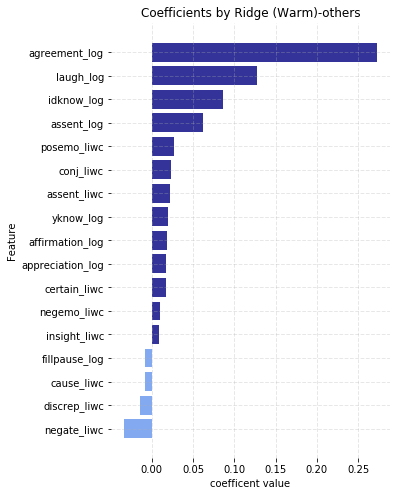

In [189]:
#warm, sorted, others
visualize_coeff(5,coeff_partner,'(Warm)-others')

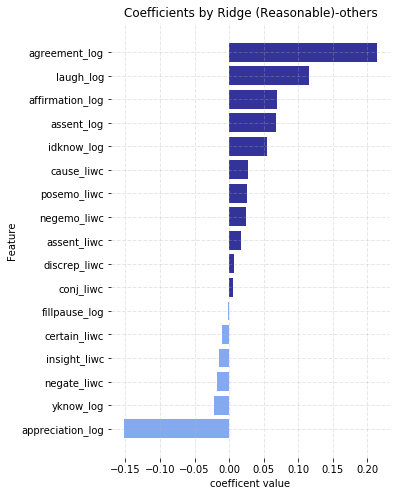

In [190]:
#reasonable, sorted, others
visualize_coeff(4,coeff_partner,'(Reasonable)-others')

##### Visualizations of feature differences by condition and person

In this part, we aim to visualize the difference of feature scores in TYB and NB condition, and also by agent.

Import all features (LIWC+self-defined):

In [191]:
df_abF0=pandas.read_csv('ab_corpora_withfeature2.csv') 

In [192]:
df_con2F0=pandas.read_csv('con_corpora_withfeature2.csv') 

In [193]:
all_feature_score=[]
all_feature_label=[]

Calculate difference of score features (NB-TYB):

In [196]:
def condition_score(fea_name):
    fea_list=df_con2F0[fea_name].groupby(df_con2F0['condition']).mean().values.tolist()
    fea_score=fea_list[0]-fea_list[1]  #NB-TYB
    return fea_score

In [197]:
appre_score=condition_score('appre_log')
all_feature_score.append(appre_score)
all_feature_label.append('appreciation_log')

affir_score=condition_score('affir_log')
all_feature_score.append(affir_score)
all_feature_label.append('affirmation_log')

assent_score=condition_score('assent_log')
all_feature_score.append(assent_score)
all_feature_label.append('assent_log')

aggree_score=condition_score('aggree_log')
all_feature_score.append(aggree_score)
all_feature_label.append('agreement_log')

#fillpause_log, laugh_log, yknow_log, idknow_log
fillpause_score=condition_score('fillpause_log')
all_feature_score.append(fillpause_score)
all_feature_label.append('fillpause_log')

laugh_score=condition_score('laugh_log')
all_feature_score.append(laugh_score)
all_feature_label.append('laugh_log')

yknow_score=condition_score('yknow_log')
all_feature_score.append(yknow_score)
all_feature_label.append('yknow_log')

idknow_score=condition_score('idknow_log')
all_feature_score.append(idknow_score)
all_feature_label.append('idknow_log')

In [198]:
#conj,posemo,negemo,insight,cause,discrep,certain,assent
conj_score=condition_score('conj')
all_feature_score.append(conj_score)
all_feature_label.append('conj_liwc')

negate_score=condition_score('negate')
all_feature_score.append(negate_score)
all_feature_label.append('negate_liwc')

posemo_score=condition_score('posemo')
all_feature_score.append(posemo_score)
all_feature_label.append('posemo_liwc')

negemo_score=condition_score('negemo')
all_feature_score.append(negemo_score)
all_feature_label.append('negemo_liwc')

insight_score=condition_score('insight')
all_feature_score.append(insight_score)
all_feature_label.append('insight_liwc')

cause_score=condition_score('cause')
all_feature_score.append(cause_score)
all_feature_label.append('cause_liwc')

discrep_score=condition_score('discrep')
all_feature_score.append(discrep_score)
all_feature_label.append('discrep_liwc')

certain_score=condition_score('certain')
all_feature_score.append(certain_score)
all_feature_label.append('certain_liwc')

assent_score=condition_score('assent')
all_feature_score.append(assent_score)
all_feature_label.append('assent_liwc')

visualization:

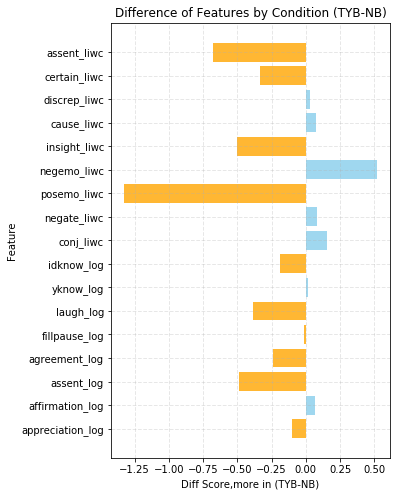

In [202]:
#visulize difference by condition, unsorted
plt.figure(figsize=(5,8))
value=all_feature_score
labels=all_feature_label
x_pos=np.arange(len(labels))

my_color=np.where(np.array(value)>=0, 'skyblue', 'orange')
plt.barh(x_pos,value,color=my_color,alpha=0.8);

plt.yticks(x_pos,labels) #,FontSize=8)
#plt.yticks([]);
plt.grid(True);
plt.grid(linestyle='--', linewidth=1,alpha=0.3)
#plt.axis('off')

plt.title("Difference of Features by Condition (TYB-NB)");
plt.xlabel('Diff Score,more in (TYB-NB)');
plt.ylabel('Feature');

In [204]:
#aggregate to dataframe 
feature_cons=pd.Series(all_feature_score,index=all_feature_label)

In [205]:
#sort values
feature_cons0=feature_cons.sort_values(ascending=False)

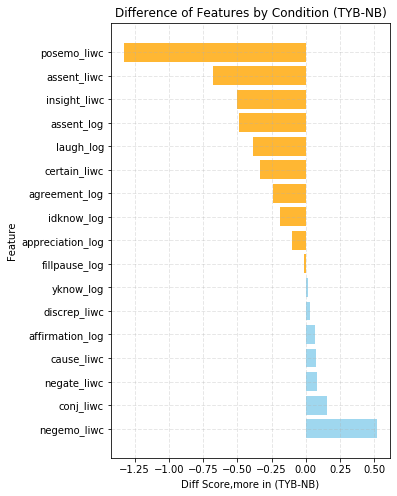

In [203]:
#visulize difference by condition,sorted
plt.figure(figsize=(5,8))
value=[x for x in feature_cons0.values]
labels=[x for x in feature_cons0.index]
x_pos=np.arange(len(labels))
bar_width=0.8

my_color=np.where(np.array(value)>=0, 'skyblue', 'orange')
plt.barh(x_pos,value,color=my_color,alpha=0.8);

plt.yticks(x_pos,labels) #,FontSize=8)
#plt.yticks([]);
plt.grid(True);
plt.grid(linestyle='--', linewidth=1,alpha=0.3)
#plt.axis('off')

plt.title("Difference of Features by Condition (TYB-NB)");
plt.xlabel('Diff Score,more in (TYB-NB)');
plt.ylabel('Feature');

Calculate difference of feature score by both condition and agent:

In [207]:
all_feature_score_A=[]
all_feature_score_B=[]
all_feature_label_ab=[]

In [208]:
df_abF0_a=df_abF0[df_abF0['agent']=='A']
df_abF0_b=df_abF0[df_abF0['agent']=='B']

In [209]:
def condition_score_ab(fea_name):
    fea_list_a=df_abF0_a[fea_name].groupby(df_abF0_a['condition']).mean().values.tolist()
    fea_score_a=fea_list_a[0]-fea_list_a[1]  #NB-TYB
    fea_list_b=df_abF0_b[fea_name].groupby(df_abF0_b['condition']).mean().values.tolist()
    fea_score_b=fea_list_b[0]-fea_list_b[1]  #NB-TYB
    all_feature_score_A.append(fea_score_a)
    all_feature_score_B.append(fea_score_b)
    return fea_score_a,fea_score_b

In [210]:
#appre_log,affir_log,assent_log,aggree_log,fillpause_log,laugh_log,yknow_log,idknow_log
condition_score_ab('appre_log')
condition_score_ab('affir_log')
condition_score_ab('assent_log')
condition_score_ab('aggree_log')
condition_score_ab('fillpause_log')
condition_score_ab('laugh_log')
condition_score_ab('yknow_log')
condition_score_ab('idknow_log')

(-0.06001233289931206, -0.17644210307129451)

In [211]:
#conj,posemo,negemo,insight,cause,discrep,certain,assent
condition_score_ab('conj')
condition_score_ab('negate')
condition_score_ab('posemo')
condition_score_ab('negemo')
condition_score_ab('insight')
condition_score_ab('cause')
condition_score_ab('discrep')
condition_score_ab('certain')
condition_score_ab('assent')

(-0.49874921826141394, -0.9143839899937469)

In [213]:
#aggregate to dataframe 
feature_cons2=pd.DataFrame({'all':all_feature_score,'PerA':all_feature_score_A,'PerB':all_feature_score_B},index=all_feature_label)

In [214]:
feature_cons2.head()

,all,PerA,PerB
appreciation_log,-0.104309,-0.104309,0.000000
affirmation_log,0.065559,0.051367,0.059175
assent_log,-0.486971,-0.406910,-0.302842
agreement_log,-0.242845,-0.118974,-0.013124
fillpause_log,-0.011363,-0.342611,0.293385


In [215]:
#sort values
feature_cons20=feature_cons2.sort_values(by='all',ascending=False)

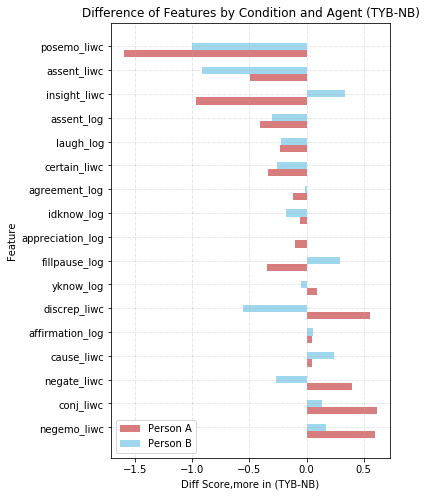

In [216]:
#visulize difference by condition & agent,sorted
plt.figure(figsize=(5,8))
value1=[x for x in feature_cons20['PerA'].values]
value2=[x for x in feature_cons20['PerB'].values]
labels=[x for x in feature_cons20.index]
x_pos=np.arange(len(labels))
bar_width=0.3

my_color1=np.where(np.array(value1)>=0, 'skyblue', 'orange')
my_color2=np.where(np.array(value2)>=0, 'skyblue', 'orange')
#plt.barh(x_pos,value1,color='IndianRed',alpha=0.8);
#plt.barh(x_pos+bar_width,value2,color='SkyBlue',alpha=0.8);
plt.barh(x_pos,value1,bar_width,color='IndianRed',alpha=0.8,label='Person A');
plt.barh(x_pos+bar_width,value2,bar_width,color='SkyBlue',alpha=0.8,label='Person B');

plt.yticks(x_pos+bar_width,labels) #,FontSize=8)
#plt.yticks([]);
plt.grid(True);
plt.grid(linestyle='--', linewidth=1,alpha=0.3)
plt.legend()
#plt.axis('off')

plt.title("Difference of Features by Condition and Agent (TYB-NB)");
plt.xlabel('Diff Score,more in (TYB-NB)');
plt.ylabel('Feature');

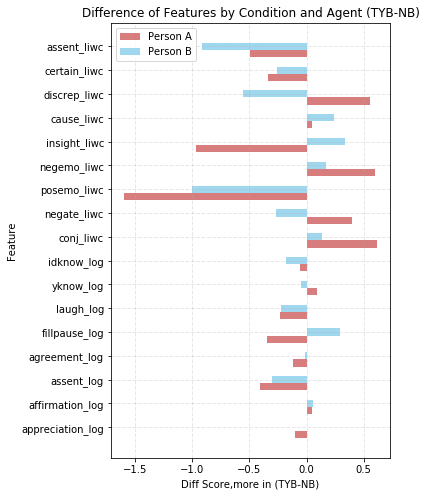

In [217]:
#visulize difference by condition & agent, unsorted 
plt.figure(figsize=(5,8))
value1=all_feature_score_A
value2=all_feature_score_B
labels=all_feature_label
x_pos=np.arange(len(labels))
bar_width=0.3

my_color1=np.where(np.array(value1)>=0, 'skyblue', 'orange')
my_color2=np.where(np.array(value2)>=0, 'skyblue', 'orange')
#plt.barh(x_pos,value1,color='IndianRed',alpha=0.8);
#plt.barh(x_pos+bar_width,value2,color='SkyBlue',alpha=0.8);
plt.barh(x_pos,value1,bar_width,color='IndianRed',alpha=0.8,label='Person A');
plt.barh(x_pos+bar_width,value2,bar_width,color='SkyBlue',alpha=0.8,label='Person B');

plt.yticks(x_pos+bar_width,labels) #,FontSize=8)
#plt.yticks([]);
plt.grid(True);
plt.grid(linestyle='--', linewidth=1,alpha=0.3)
plt.legend()
#plt.axis('off')

plt.title("Difference of Features by Condition and Agent (TYB-NB)");
plt.xlabel('Diff Score,more in (TYB-NB)');
plt.ylabel('Feature');

### Part-2 Pairwise similarity & Across Time

For this part of analysis, we aim to examine how pairwise similarity of corpora changes across time/turns. We calculated pairwise similarity/divergence score based on both 1) linguistic features we defined and 2) Good word embeddings of the whole corpora.

a. Pairwise similarity based on **17 linguistic features**:

In [219]:
np_abfeatures.shape

(160, 17)

In [220]:
import scipy

Calculate divergence score (Jensen-Shannon Divergence)between any two person by their 17 linguistic features:

In [221]:
#divergence score
def js_sim(a,b):
    M=(a+b)/2
    return 0.5*scipy.stats.entropy(a, M)+0.5*scipy.stats.entropy(b, M)

Calculate divergence score between pairs:

In [224]:
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(len(df_con2)):
    condition=df_abF0['condition'][2*i]
    a=np_abfeatures[2*i]
    b=np_abfeatures[2*i+1]
    AB_sim=js_sim(a,b)
    if condition=='TYB':
        sim_pair_TYB.append(AB_sim)
    elif condition=='NB':
        sim_pair_NB.append(AB_sim)

In [225]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg divergence of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg divergence of pair in NB',round(float(avg_sim_pair_NB),4))

Avg divergence of pair in TYB 0.0752
Avg divergence of pair in NB 0.0751


Calculate divergence score between 1) any two people; 2) any two person who are Person A; 2) any two person who are Person B.

In [226]:
sim_all,sim_all_A_TYB,sim_all_B_TYB,sim_all_A_NB,sim_all_B_NB=[],[],[],[],[]
for i in range(len(df_AB)):
    for j in range(len(df_AB)):
        if j>i:
            a=np_abfeatures[i]
            b=np_abfeatures[j]            
            AB_sim=js_sim(a,b)
            sim_all.append(AB_sim)
            if df_AB['agent'][i]=='A'and df_AB['condition'][i]=='TYB'and df_AB['agent'][j]=='A'and df_AB['condition'][j]=='TYB':
                sim_all_A_TYB.append(AB_sim)
            elif df_AB['agent'][i]=='B'and df_AB['condition'][i]=='TYB'and df_AB['agent'][j]=='B'and df_AB['condition'][j]=='TYB':
                sim_all_B_TYB.append(AB_sim)
            elif df_AB['agent'][i]=='A'and df_AB['condition'][i]=='NB'and df_AB['agent'][j]=='A'and df_AB['condition'][j]=='NB':
                sim_all_A_NB.append(AB_sim)
            elif df_AB['agent'][i]=='B'and df_AB['condition'][i]=='NB'and df_AB['agent'][j]=='B'and df_AB['condition'][j]=='NB':
                sim_all_B_NB.append(AB_sim)

In [227]:
avg_sim_all=sum(sim_all)/len(sim_all)
avg_sim_all_A_TYB=sum(sim_all_A_TYB)/len(sim_all_A_TYB)
avg_sim_all_B_TYB=sum(sim_all_B_TYB)/len(sim_all_B_TYB)
avg_sim_all_A_NB=sum(sim_all_A_NB)/len(sim_all_A_NB)
avg_sim_all_B_NB=sum(sim_all_B_NB)/len(sim_all_B_NB)
print('Avg similarity between any two subjs',round(float(avg_sim_all),4))
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity between any two subjs 0.0838
Avg similarity of pair in TYB 0.0752
Avg similarity of pair in NB 0.0751


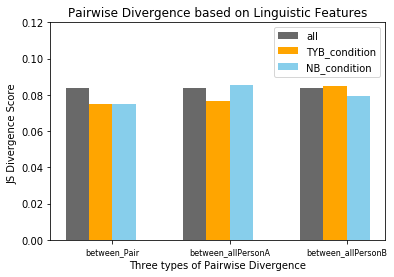

In [333]:
label0=['between_Pair','between_allPersonA','between_allPersonB']
index=np.arange(len(label0))
width=0.2

avg_all=[float(avg_sim_all),float(avg_sim_all),float(avg_sim_all)]
avg_TYB=[float(avg_sim_pair_TYB),float(avg_sim_all_A_TYB),float(avg_sim_all_B_TYB)]
avg_NB=[float(avg_sim_pair_NB),float(avg_sim_all_A_NB),float(avg_sim_all_B_NB)]

plt.bar(index,avg_all,width,color='dimgrey',label='all') 
plt.bar(index+width,avg_TYB,width,color='orange',label='TYB_condition') 
plt.bar(index+width+width,avg_NB,width,color='skyblue',label='NB_condition') 

plt.xlabel('Three types of Pairwise Divergence')
plt.ylabel('JS Divergence Score ')
plt.xticks(index+width*1.5,label0,FontSize=8)
plt.ylim(0,0.12)
plt.legend()
plt.title('Pairwise Divergence based on Linguistic Features');

Calculated pairwise similarity based on cosine similarity score:

In [228]:
import sklearn

In [229]:
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(len(df_con2)):
    condition=df_abF0['condition'][2*i]
    a=np_abfeatures[2*i].reshape(1, -1)
    b=np_abfeatures[2*i+1].reshape(1, -1)
    AB_sim=sklearn.metrics.pairwise.cosine_similarity(a,b)
    if condition=='TYB':
        sim_pair_TYB.append(AB_sim)
    elif condition=='NB':
        sim_pair_NB.append(AB_sim)

In [230]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity of pair in TYB 0.874
Avg similarity of pair in NB 0.8827


In [231]:
sim_all,sim_all_A_TYB,sim_all_B_TYB,sim_all_A_NB,sim_all_B_NB=[],[],[],[],[]
for i in range(len(df_AB)):
    for j in range(len(df_AB)):
        if j>i:
            a=np_abfeatures[i].reshape(1, -1)
            b=np_abfeatures[j].reshape(1, -1)            
            AB_sim=sklearn.metrics.pairwise.cosine_similarity(a,b)
            sim_all.append(AB_sim)
            if df_AB['agent'][i]=='A'and df_AB['condition'][i]=='TYB'and df_AB['agent'][j]=='A'and df_AB['condition'][j]=='TYB':
                sim_all_A_TYB.append(AB_sim)
            elif df_AB['agent'][i]=='B'and df_AB['condition'][i]=='TYB'and df_AB['agent'][j]=='B'and df_AB['condition'][j]=='TYB':
                sim_all_B_TYB.append(AB_sim)
            elif df_AB['agent'][i]=='A'and df_AB['condition'][i]=='NB'and df_AB['agent'][j]=='A'and df_AB['condition'][j]=='NB':
                sim_all_A_NB.append(AB_sim)
            elif df_AB['agent'][i]=='B'and df_AB['condition'][i]=='NB'and df_AB['agent'][j]=='B'and df_AB['condition'][j]=='NB':
                sim_all_B_NB.append(AB_sim)

In [232]:
avg_sim_all=sum(sim_all)/len(sim_all)
avg_sim_all_A_TYB=sum(sim_all_A_TYB)/len(sim_all_A_TYB)
avg_sim_all_B_TYB=sum(sim_all_B_TYB)/len(sim_all_B_TYB)
avg_sim_all_A_NB=sum(sim_all_A_NB)/len(sim_all_A_NB)
avg_sim_all_B_NB=sum(sim_all_B_NB)/len(sim_all_B_NB)
print('Avg similarity between any two subjs',round(float(avg_sim_all),4))
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity between any two subjs 0.863
Avg similarity of pair in TYB 0.874
Avg similarity of pair in NB 0.8827


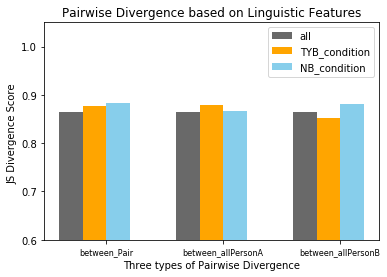

In [87]:
label0=['between_Pair','between_allPersonA','between_allPersonB']
index=np.arange(len(label0))
width=0.2

avg_all=[float(avg_sim_all),float(avg_sim_all),float(avg_sim_all)]
avg_TYB=[float(avg_sim_pair_TYB),float(avg_sim_all_A_TYB),float(avg_sim_all_B_TYB)]
avg_NB=[float(avg_sim_pair_NB),float(avg_sim_all_A_NB),float(avg_sim_all_B_NB)]

plt.bar(index,avg_all,width,color='dimgrey',label='all') 
plt.bar(index+width,avg_TYB,width,color='orange',label='TYB_condition') 
plt.bar(index+width+width,avg_NB,width,color='skyblue',label='NB_condition') 

plt.xlabel('Three types of Pairwise Divergence')
plt.ylabel('JS Divergence Score ')
plt.xticks(index+width*1.5,label0,FontSize=8)
plt.ylim(0.6,1.05)
plt.legend()
plt.title('Pairwise Divergence based on Linguistic Features');

From the similarity score above, we could see that aligning with expectation: 1) pairwise similairty is highest within pairs(blue and orange bar in the left, compared with grey bar-the overall averaged similarity score of any two people); 2) similarity between person A is highest in TYB condition. 

However, what is unexpected is that: 1) pairwise similarity within pair is highest in NB condition; 2) similarity between PersonB is highest in NB condition. 

b. Pairwise similarity based on **Google Word Embeddings**:

##### Prepare to build word vectors based on Google Word2Vec models：
1. Normalization, specialized for this study, which will not filter out words like, 'you','i','mhm', which we are interested in
2. Use different dataframe which will not take interjections into account (preprocessed in the Appendix section at the last part of this jupyter notebook, which yields new dataframe-df_con3, df_AB0, df_AB_turn0 for this study)

In [286]:
#normalization, which will not exclude tokens we are interested in
stop_words_freq=['that','this','the','it','a','to',"'s",'of',"n't",'is','be']
import spacy
nlp = spacy.load("en")

def normalizeTokens2(word_list, extra_stop=[], model=nlp, lemma=True):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = 1500000
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                if w.text not in stop_words_freq:
                        if w.lemma_!='-PRON-':
                            normalized.append(str(w.lemma_))
                        else:
                            normalized.append(str(w.text))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the non-lematized version of the word    
                if w.text not in stop_words_freq:
                    normalized.append(str(w.text.strip()))


    return normalized

In [337]:
#Apply our functions, notice each row is a list of lists now
df_con3['tokenized_sents_all'] = df_con3['conversation_txt'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_con3['tokenized_sents_A'] = df_con3['con_txt_A'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_con3['tokenized_sents_B'] = df_con3['con_txt_B'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])

In [338]:
df_con3['normalized_sents_all'] = df_con3['tokenized_sents_all'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
df_con3['normalized_sents_A'] = df_con3['tokenized_sents_A'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
df_con3['normalized_sents_B'] = df_con3['tokenized_sents_B'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])

In [289]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [339]:
df_AB_turn0['normalized_words'] = df_AB_turn0['tokenized_text'].apply(lambda x: normalizeTokens2(x, lemma=False))

In [340]:
df_AB0['tokenized_words'] = df_AB0['con_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_AB0['normalized_words'] = df_AB0['tokenized_words'].apply(lambda x: normalizeTokens2(x, lemma=False))

In [341]:
df_con3['tokenized_words'] = df_con3['conversation_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_con3['normalized_words'] = df_con3['tokenized_words'].apply(lambda x: normalizeTokens2(x, lemma=False))

In [293]:
def word2docvec(wordlist):
    doc_vec0=[model[x] for x in wordlist if x in model]
    if len(doc_vec0)==0:
        doc_vec=np.nan
    else:
        doc_vec=sum(doc_vec0)/len(doc_vec0)
    return doc_vec

In [342]:
df_AB0['doc_vec_g']=df_AB0['normalized_words'].apply(lambda x: word2docvec(x))
df_con3['doc_vec_g']=df_con3['normalized_words'].apply(lambda x: word2docvec(x))

In [343]:
df_AB_turn0['doc_vec_g']=df_AB_turn0['normalized_words'].apply(lambda x: word2docvec(x))

##### Calculate Pairwise Similarity  based on Word Embeddings

In [345]:
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(len(df_con3)):
    condition=df_AB0['condition'][2*i]
    A_vec=df_AB0['doc_vec_g'][2*i].reshape(1, -1)
    B_vec=df_AB0['doc_vec_g'][2*i+1].reshape(1, -1)
    AB_sim=sklearn.metrics.pairwise.cosine_similarity(A_vec,B_vec)
    if condition=='TYB':
        sim_pair_TYB.append(AB_sim)
    elif condition=='NB':
        sim_pair_NB.append(AB_sim)

In [346]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity of pair in TYB 0.9568
Avg similarity of pair in NB 0.9585


In [348]:
sim_all,sim_all_A_TYB,sim_all_B_TYB,sim_all_A_NB,sim_all_B_NB=[],[],[],[],[]
for i in range(len(df_AB0)):
    for j in range(len(df_AB0)):
        if j>i:
            A_vec=df_AB0['doc_vec_g'][i].reshape(1, -1)
            B_vec=df_AB0['doc_vec_g'][j].reshape(1, -1)
            AB_sim=sklearn.metrics.pairwise.cosine_similarity(A_vec,B_vec)
            sim_all.append(AB_sim)
            if df_AB0['agent'][i]=='A'and df_AB0['condition'][i]=='TYB'and df_AB0['agent'][j]=='A'and df_AB0['condition'][j]=='TYB':
                sim_all_A_TYB.append(AB_sim)
            elif df_AB0['agent'][i]=='B'and df_AB0['condition'][i]=='TYB'and df_AB0['agent'][j]=='B'and df_AB0['condition'][j]=='TYB':
                sim_all_B_TYB.append(AB_sim)
            elif df_AB0['agent'][i]=='A'and df_AB0['condition'][i]=='NB'and df_AB0['agent'][j]=='A'and df_AB0['condition'][j]=='NB':
                sim_all_A_NB.append(AB_sim)
            elif df_AB0['agent'][i]=='B'and df_AB0['condition'][i]=='NB'and df_AB0['agent'][j]=='B'and df_AB0['condition'][j]=='NB':
                sim_all_B_NB.append(AB_sim)

In [349]:
avg_sim_all=sum(sim_all)/len(sim_all)
avg_sim_all_A_TYB=sum(sim_all_A_TYB)/len(sim_all_A_TYB)
avg_sim_all_B_TYB=sum(sim_all_B_TYB)/len(sim_all_B_TYB)
avg_sim_all_A_NB=sum(sim_all_A_NB)/len(sim_all_A_NB)
avg_sim_all_B_NB=sum(sim_all_B_NB)/len(sim_all_B_NB)
print('Avg similarity between any two subjs',round(float(avg_sim_all),4))
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity between any two subjs 0.9398
Avg similarity of pair in TYB 0.9568
Avg similarity of pair in NB 0.9585


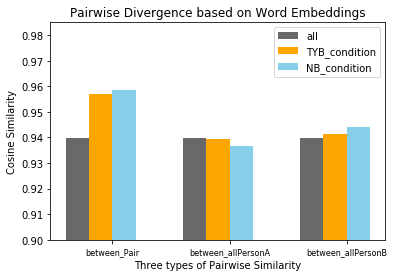

In [350]:
label0=['between_Pair','between_allPersonA','between_allPersonB']
index=np.arange(len(label0))
width=0.2

avg_all=[float(avg_sim_all),float(avg_sim_all),float(avg_sim_all)]
avg_TYB=[float(avg_sim_pair_TYB),float(avg_sim_all_A_TYB),float(avg_sim_all_B_TYB)]
avg_NB=[float(avg_sim_pair_NB),float(avg_sim_all_A_NB),float(avg_sim_all_B_NB)]

plt.bar(index,avg_all,width,color='dimgrey',label='all') 
plt.bar(index+width,avg_TYB,width,color='orange',label='TYB_condition') 
plt.bar(index+width+width,avg_NB,width,color='skyblue',label='NB_condition') 

plt.xlabel('Three types of Pairwise Similarity')
plt.ylabel('Cosine Similarity')
plt.xticks(index+width*1.5,label0,FontSize=8)
plt.ylim(0.9,0.985)
plt.legend()
plt.title('Pairwise Divergence based on Word Embeddings');

c. Pairwise similarity changes across Turns based on **Linguistic Features**:

Turns are framed as 'turns position' into 3 categories: 1/3 first turns, 1/3 middle turns, 1/3 last turns, relative to the various turns numbers of each conversation.

In [233]:
df=df_AB_turn

In [239]:
#pairwise divergence for each 'turn position'
df=df_AB_turn
df_con_sim2=df_con2
df_con_sim2['pair_sim']=[[]]*len(df_con_sim2)
df_con_sim2['pair_sim1']=0*len(df_con_sim2)
df_con_sim2['pair_sim2']=0*len(df_con_sim2)
df_con_sim2['pair_sim3']=0*len(df_con_sim2)
sim_pair1=[]
sim_pair2=[]
sim_pair3=[]
for i,row in df_con_sim2.iterrows():
    turn_num_A=len(row['round_A'])
    turn_num_B=len(row['round_B'])
    pair_id=row['pair_id']
    turn_num=min(turn_num_A,turn_num_B)
    sim_pair=[]
    for turn in range(turn_num):        
        if turn==(turn_num-1) and turn_num_A!=turn_num_B:
            if turn_num_A>turn_num_B:
                A10=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')].index
                A20=df[(df['pair_id']==pair_id) & (df['round']==(turn+2)) & (df['agent']=='A')].index
                B1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')].index
                a=(np_turnfeatures[A10[0]].astype(float)+np_turnfeatures[A20[0]].astype(float))/2  #.reshape(1, -1)
                b=np_turnfeatures[B1[0]]            
            elif turn_num_B>turn_num_A:
                B10=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')].index
                B20=df[(df['pair_id']==pair_id) & (df['round']==(turn+2)) & (df['agent']=='B')].index
                A1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')].index
                b=(np_turnfeatures[B10[0]].astype(float)+np_turnfeatures[B20[0]].astype(float))/2  #.reshape(1, -1)
                a=np_turnfeatures[A1[0]]  
        else:
            A1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')].index
            B1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')].index
            b=np_turnfeatures[B1[0]]  #.reshape(1, -1)
            a=np_turnfeatures[A1[0]]            
        turn_sim=js_sim(a.astype(float),b.astype(float))
        #sklearn.metrics.pairwise.cosine_similarity(A1_vec,B1_vec)
        sim_pair.append(float(turn_sim))     
        
    if turn_num==2:
        sim_pair_1=sim_pair[0]
        sim_pair_2=sim_pair[1]
        sim_pair_3=0
    elif turn_num==3:
        sim_pair_1=sim_pair[0]
        sim_pair_2=sim_pair[1]
        sim_pair_3=sim_pair[2]
    elif turn_num==4:
        sim_pair_1=sim_pair[0]
        sim_pair_2=(sim_pair[1]+sim_pair[2])/2
        sim_pair_3=sim_pair[3]
    elif turn_num==5:
        sim_pair_1=(sim_pair[0]+sim_pair[1])/2
        sim_pair_2=(sim_pair[2]+sim_pair[3])/2
        sim_pair_3=sim_pair[4]
    elif turn_num==6:
        sim_pair_1=(sim_pair[0]+sim_pair[1])/2
        sim_pair_2=(sim_pair[2]+sim_pair[3])/2
        sim_pair_3=(sim_pair[4]+sim_pair[5])/2   
    elif turn_num==7:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4])/2
        sim_pair_3=(sim_pair[5]+sim_pair[6])/2 
    elif turn_num==8:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5])/3
        sim_pair_3=(sim_pair[6]+sim_pair[7])/2 
    elif turn_num==9:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5])/3
        sim_pair_3=(sim_pair[6]+sim_pair[7]+sim_pair[8])/3
    elif turn_num==10:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5]+sim_pair[6])/4
        sim_pair_3=(sim_pair[7]+sim_pair[8]+sim_pair[9])/3
    else:
        sim_pair_1=0
        sim_pair_2=0
        sim_pair_3=0
    df_con_sim2['pair_sim'][i]=sim_pair
    sim_pair1.append(sim_pair_1)
    sim_pair2.append(sim_pair_2)
    sim_pair3.append(sim_pair_3)
    #df_con2['pair_sim1'][i]=sim_pair_1
    #df_con2['pair_sim2'][i]=sim_pair_2
    #df_con2['pair_sim3'][i]=sim_pair_3

C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [240]:
df_con_sim2['pair_sim1']=sim_pair1
df_con_sim2['pair_sim2']=sim_pair2
df_con_sim2['pair_sim3']=sim_pair3

In [241]:
#averaged across conditions
avg_sim_turn1_TYB=np.mean(df_con_sim2[df_con_sim2['condition']=='TYB']['pair_sim1'])
avg_sim_turn1_NB=np.mean(df_con_sim2[df_con_sim2['condition']=='NB']['pair_sim1'])
avg_sim_turn2_TYB=np.mean(df_con_sim2[df_con_sim2['condition']=='TYB']['pair_sim2'])
avg_sim_turn2_NB=np.mean(df_con_sim2[df_con_sim2['condition']=='NB']['pair_sim2'])
avg_sim_turn3_TYB=np.mean(df_con_sim2[df_con_sim2['condition']=='TYB']['pair_sim3'])
avg_sim_turn3_NB=np.mean(df_con_sim2[df_con_sim2['condition']=='NB']['pair_sim3'])

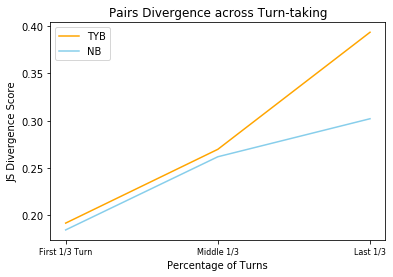

In [242]:
turn_TYB=[avg_sim_turn1_TYB,avg_sim_turn2_TYB,avg_sim_turn3_TYB] #avg_sim_turn4_TYB,avg_sim_lturn3_TYB,avg_sim_lturn2_TYB,avg_sim_lturn1_TYB]
turn_NB=[avg_sim_turn1_NB,avg_sim_turn2_NB,avg_sim_turn3_NB] #,avg_sim_turn4_NB,avg_sim_lturn3_NB,avg_sim_lturn2_NB,avg_sim_lturn1_NB]
turn_TYB=[float(x) for x in turn_TYB]
turn_NB=[float(x) for x in turn_NB]
label0=['First 1/3 Turn','Middle 1/3','Last 1/3']
index=np.arange(len(label0))

plt.plot(index,turn_TYB,color='Orange',label='TYB')
plt.plot(index,turn_NB,color='Skyblue',label='NB')

plt.xlabel('Percentage of Turns')
plt.ylabel('JS Divergence Score')
plt.xticks(index,label0,FontSize=8)
plt.legend()
plt.title('Pairs Divergence across Turn-taking');

In [24]:
turn_label_countPcate=df_AB_turn.groupby('turn_label').count()['index']
turn_label_countPcate

turn_label
1    238
2    272
3    204
Name: index, dtype: int64

Overall, the divergence within pairs of TYB is higher than NB; Moreover, the divergence increases greater than NB at the end of the conversation (while the number of turns in this category is not that significant less than the first and middle 1/3 turn positions).

d. Pairwise similarity changes across Turns based on **Google Word Embeddings**:

In [355]:
#similarity for each turn
df=df_AB_turn0
df_con_sim=df_con3
#df_con_sim=df_con2
df_con_sim['pair_sim']=[[]]*len(df_con_sim)
df_con_sim['pair_sim1']=0*len(df_con_sim)
df_con_sim['pair_sim2']=0*len(df_con_sim)
df_con_sim['pair_sim3']=0*len(df_con_sim)
sim_pair1=[]
sim_pair2=[]
sim_pair3=[]
for i,row in df_con_sim.iterrows():
    turn_num_A=len(row['round_A'])
    turn_num_B=len(row['round_B'])
    pair_id=row['pair_id']
    turn_num=min(turn_num_A,turn_num_B)
    sim_pair=[]
    for turn in range(turn_num):        
        if turn==(turn_num-1) and turn_num_A!=turn_num_B:
            if turn_num_A>turn_num_B:
                A10=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')]['doc_vec_g']
                A20=df[(df['pair_id']==pair_id) & (df['round']==(turn+2)) & (df['agent']=='A')]['doc_vec_g']
                B1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')]['doc_vec_g']
                a10=[v for i,v in A10.items()][0]
                a20=[v for i,v in A20.items()][0]
                a1=(a10+a20)/2
                A1_vec=a1.reshape(1, -1)
                b1=[v for i,v in B1.items()]
                B1_vec=b1[0].reshape(1, -1)
            elif turn_num_B>turn_num_A:
                B10=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')]['doc_vec_g']
                B20=df[(df['pair_id']==pair_id) & (df['round']==(turn+2)) & (df['agent']=='B')]['doc_vec_g']
                A1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')]['doc_vec_g']
                b10=[v for i,v in B10.items()][0]
                b20=[v for i,v in B20.items()][0]
                b1=(b10+b20)/2
                B1_vec=b1.reshape(1, -1)
                a1=[v for i,v in A1.items()]
                A1_vec=a1[0].reshape(1, -1) 
        else:
            A1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='A')]['doc_vec_g']
            B1=df[(df['pair_id']==pair_id) & (df['round']==turn+1) & (df['agent']=='B')]['doc_vec_g']
            a1=[v for i,v in A1.items()]
            b1=[v for i,v in B1.items()]
            A1_vec=a1[0].reshape(1, -1)
            B1_vec=b1[0].reshape(1, -1)            
        turn_sim=sklearn.metrics.pairwise.cosine_similarity(A1_vec,B1_vec)
        sim_pair.append(float(turn_sim))     
        
    if turn_num==2:
        sim_pair_1=sim_pair[0]
        sim_pair_2=sim_pair[1]
        sim_pair_3=0
    elif turn_num==3:
        sim_pair_1=sim_pair[0]
        sim_pair_2=sim_pair[1]
        sim_pair_3=sim_pair[2]
    elif turn_num==4:
        sim_pair_1=sim_pair[0]
        sim_pair_2=(sim_pair[1]+sim_pair[2])/2
        sim_pair_3=sim_pair[3]
    elif turn_num==5:
        sim_pair_1=(sim_pair[0]+sim_pair[1])/2
        sim_pair_2=(sim_pair[2]+sim_pair[3])/2
        sim_pair_3=sim_pair[4]
    elif turn_num==6:
        sim_pair_1=(sim_pair[0]+sim_pair[1])/2
        sim_pair_2=(sim_pair[2]+sim_pair[3])/2
        sim_pair_3=(sim_pair[4]+sim_pair[5])/2   
    elif turn_num==7:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4])/2
        sim_pair_3=(sim_pair[5]+sim_pair[6])/2 
    elif turn_num==8:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5])/3
        sim_pair_3=(sim_pair[6]+sim_pair[7])/2 
    elif turn_num==9:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5])/3
        sim_pair_3=(sim_pair[6]+sim_pair[7]+sim_pair[8])/3
    elif turn_num==10:
        sim_pair_1=(sim_pair[0]+sim_pair[1]+sim_pair[2])/3
        sim_pair_2=(sim_pair[3]+sim_pair[4]+sim_pair[5]+sim_pair[6])/4
        sim_pair_3=(sim_pair[7]+sim_pair[8]+sim_pair[9])/3
    else:
        sim_pair_1=0
        sim_pair_2=0
        sim_pair_3=0
    df_con_sim['pair_sim'][i]=sim_pair
    sim_pair1.append(sim_pair_1)
    sim_pair2.append(sim_pair_2)
    sim_pair3.append(sim_pair_3)
    #df_con2['pair_sim1'][i]=sim_pair_1
    #df_con2['pair_sim2'][i]=sim_pair_2
    #df_con2['pair_sim3'][i]=sim_pair_3

C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWar

C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWar

C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWar

In [356]:
df_con_sim['pair_sim1']=sim_pair1
df_con_sim['pair_sim2']=sim_pair2
df_con_sim['pair_sim3']=sim_pair3

In [357]:
avg_sim_turn1_TYB=np.mean(df_con_sim[df_con_sim['condition']=='TYB']['pair_sim1'])
avg_sim_turn1_NB=np.mean(df_con_sim[df_con_sim['condition']=='NB']['pair_sim1'])
avg_sim_turn2_TYB=np.mean(df_con_sim[df_con_sim['condition']=='TYB']['pair_sim2'])
avg_sim_turn2_NB=np.mean(df_con_sim[df_con_sim['condition']=='NB']['pair_sim2'])
avg_sim_turn3_TYB=np.mean(df_con_sim[df_con_sim['condition']=='TYB']['pair_sim3'])
avg_sim_turn3_NB=np.mean(df_con_sim[df_con_sim['condition']=='NB']['pair_sim3'])

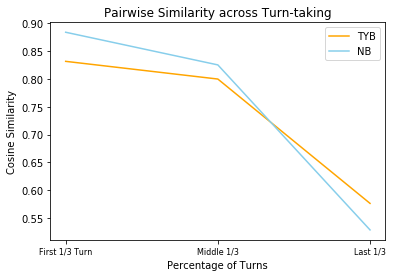

In [358]:
turn_TYB=[avg_sim_turn1_TYB,avg_sim_turn2_TYB,avg_sim_turn3_TYB] #avg_sim_turn4_TYB,avg_sim_lturn3_TYB,avg_sim_lturn2_TYB,avg_sim_lturn1_TYB]
turn_NB=[avg_sim_turn1_NB,avg_sim_turn2_NB,avg_sim_turn3_NB] #,avg_sim_turn4_NB,avg_sim_lturn3_NB,avg_sim_lturn2_NB,avg_sim_lturn1_NB]
turn_TYB=[float(x) for x in turn_TYB]
turn_NB=[float(x) for x in turn_NB]
label0=['First 1/3 Turn','Middle 1/3','Last 1/3']
index=np.arange(len(label0))

plt.plot(index,turn_TYB,color='Orange',label='TYB')
plt.plot(index,turn_NB,color='Skyblue',label='NB')

plt.xlabel('Percentage of Turns')
plt.ylabel('Cosine Similarity')
plt.xticks(index,label0,FontSize=8)
plt.legend()
plt.title('Pairwise Similarity across Turn-taking');

### Part-3 Feature Score changes across Time/Turns:

Visualize how each feature score/dimension changes across time, based on: 
1. 17 Linguistic Features
2. Google word Embeddings **(in Part2 Jupyter Notebook)**

*Time label is tagged into 6 intervals: 0-30s, 30-60s, 60-90s, 90-120s, 120-150s, 150-180s.*

In [245]:
#number of turns for each interval
time_label_countPcate

time_label
1    147
2    101
3     96
4    107
5    144
6    117
7      2
Name: index, dtype: int64

*Turn Position is defined by 1/3 first, 1/3 middle, 1/3 last turns:*

In [271]:
turn_label_countPcate=df_AB_turn.groupby('turn_label').count()['index']
turn_label_countPcate

turn_label
1    238
2    272
3    204
Name: index, dtype: int64

a. 17 Linguistic Features change across time (180s):

In [244]:
#import all features for each turn
df_AB_turnF0=pandas.read_csv('turn_corpora_withfeature2.csv') 

In [272]:
df_AB_turnF0['time_label']=df_AB_turnF0['time'].apply(lambda x: time_label(x))
df_AB_turnF0['turn_label']=df_AB_turn['turn_label']

In [259]:
df_turnF.head()

,appre_log,affir_log,assent_log,aggree_log,fillpause_log,laugh_log,yknow_log,idknow_log,conj,negate,posemo,negemo,insight,cause,discrep,certain,assent
0,0.0,0.000000,0.693147,0.0,0.693147,0.0,1.609438,0.0,6.98,2.33,1.86,1.40,6.98,2.33,2.33,1.86,0.47
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.609438,0.0,9.26,4.32,0.62,3.09,7.41,1.23,0.62,0.62,0.00
2,0.0,0.693147,0.000000,0.0,1.098612,0.0,0.000000,0.0,11.76,2.35,3.53,2.35,7.06,4.71,2.35,0.00,1.18
3,0.0,0.000000,0.693147,0.0,0.000000,0.0,0.000000,0.0,12.24,2.04,6.12,4.08,6.12,4.08,2.04,10.20,14.29
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,6.15,3.08,3.08,1.54,4.62,0.00,1.54,1.54,1.54


Aggregate and Visualize feature scores by condition and agent:

In [276]:
def feature_across_time(feat_name,feat_discrip,liwc=0):
    aff_A_TYB=df_AB_turnF0[(df_AB_turnF0['condition']=='TYB') & (df_AB_turnF0['agent']=='A')].groupby('time_label').mean()[feat_name]
    aff_A_TYB=list(aff_A_TYB)
    aff_B_TYB=df_AB_turnF0[(df_AB_turnF0['condition']=='TYB') & (df_AB_turnF0['agent']=='B')].groupby('time_label').mean()[feat_name]
    aff_B_TYB=list(aff_B_TYB)

    aff_A_NB=df_AB_turnF0[(df_AB_turnF0['condition']=='NB') & (df_AB_turnF0['agent']=='A')].groupby('time_label').mean()[feat_name]
    aff_A_NB=list(aff_A_NB)
    aff_B_NB=df_AB_turnF0[(df_AB_turnF0['condition']=='NB') & (df_AB_turnF0['agent']=='B')].groupby('time_label').mean()[feat_name]
    aff_B_NB=list(aff_B_NB)
    
    label0=['0-30s','30-60s','60-90s','90-120s','120-150s','150-180s']
    index=np.arange(len(label0))

    plt.plot(index,aff_A_TYB[:6],color='orange',label='TYB_A')
    plt.plot(index,aff_B_TYB[:6],color='orange',linestyle='dashed',label='TYB_B')
    plt.plot(index,aff_A_NB[:6],color='skyblue',label='NB_A')
    plt.plot(index,aff_B_NB[:6],color='skyblue',linestyle='dashed',label='NB_B')

    plt.xlabel('Time')
    if liwc==0:
        ylabel0='Averaged LIWC Score'
    else:
        ylabel0='Averaged Counts'
    plt.ylabel(ylabel0)
    plt.xticks(index,label0,FontSize=8)
    plt.legend()
    if liwc==0:
        title0='Change of LIWC '+feat_discrip+' across time'
    else:
        title0='Change of Feature '+feat_discrip+' across time'
    plt.title(title0);

In [277]:
def feature_across_turns(feat_name,feat_discrip,liwc=0):
    aff_A_TYB=df_AB_turnF0[(df_AB_turnF0['condition']=='TYB') & (df_AB_turnF0['agent']=='A')].groupby('turn_label').mean()[feat_name]
    aff_A_TYB=list(aff_A_TYB)
    aff_B_TYB=df_AB_turnF0[(df_AB_turnF0['condition']=='TYB') & (df_AB_turnF0['agent']=='B')].groupby('turn_label').mean()[feat_name]
    aff_B_TYB=list(aff_B_TYB)

    aff_A_NB=df_AB_turnF0[(df_AB_turnF0['condition']=='NB') & (df_AB_turnF0['agent']=='A')].groupby('turn_label').mean()[feat_name]
    aff_A_NB=list(aff_A_NB)
    aff_B_NB=df_AB_turnF0[(df_AB_turnF0['condition']=='NB') & (df_AB_turnF0['agent']=='B')].groupby('turn_label').mean()[feat_name]
    aff_B_NB=list(aff_B_NB)
    
    aff_TYB=df_AB_turnF0[(df_AB_turnF0['condition']=='TYB')].groupby('turn_label').mean()[feat_name]
    aff_TYB=list(aff_TYB)

    aff_NB=df_AB_turnF0[(df_AB_turnF0['condition']=='NB')].groupby('turn_label').mean()[feat_name]
    aff_NB=list(aff_NB)
    
    label0=['TYB','NB']
    index=np.arange(len(label0))
    width=0.3

    avg_1=[aff_TYB[0],aff_NB[0]]
    avg_2=[aff_TYB[1],aff_NB[1]]
    avg_3=[aff_TYB[2],aff_NB[2]]

    colors=['orange','skyblue']
    plt.bar(index,avg_1,width,color=colors,label='First 1/3 Turns') 
    plt.bar(index+width,avg_2,width,color=colors,alpha=0.6,label='Middle 1/3')
    plt.bar(index+width+width,avg_3,width,color=colors,alpha=0.3,label='Last 1/3')

    plt.xlabel('TurnPosition*Condition')
    if liwc==0:
        ylabel0='Averaged LIWC Score'
    else:
        ylabel0='Averaged Counts'
    plt.ylabel(ylabel0)
    plt.xticks(index+width,label0,FontSize=8)
    plt.legend()
    if liwc==0:
        title0='Change of LIWC '+feat_discrip+' across Turns'
    else:
        title0='Change of Feature '+feat_discrip+' across Turns'
    plt.title(title0);

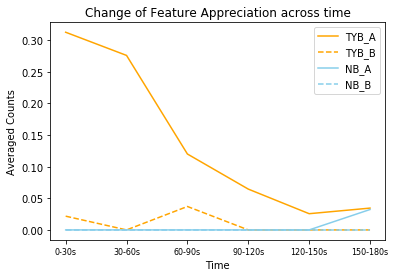

In [279]:
#Feature Appreciation
feature_across_time('appre_c','Appreciation',1)

From the figure above and below, we could clearly see that, the 'appreciation' feature is a good manipulation check that high in TYB condition and nearly to zero in NB condition. Also in TYB condition, the score is much higher at the beginning and gradually drops across time and turns.

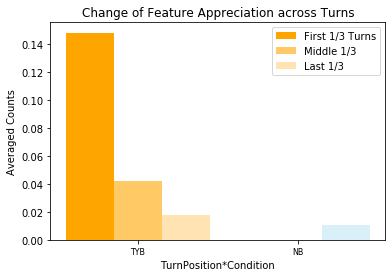

In [278]:
#Feature Appreciation
feature_across_turns('appre_c','Appreciation',1)

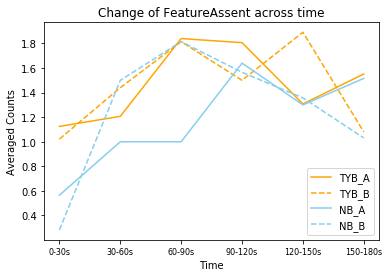

In [260]:
#Feature Assent
feature_across_time('assent_c','Assent',1)

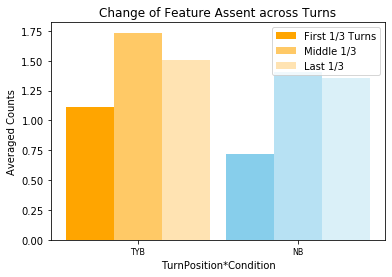

In [280]:
#Feature Assent
feature_across_turns('assent_c','Assent',1)

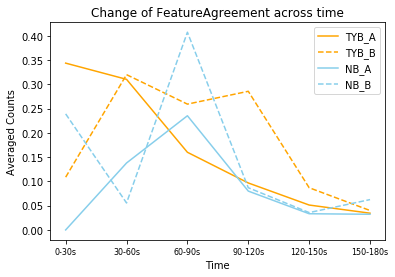

In [261]:
#Feature Agreement
feature_across_time('aggree_c','Agreement',1)

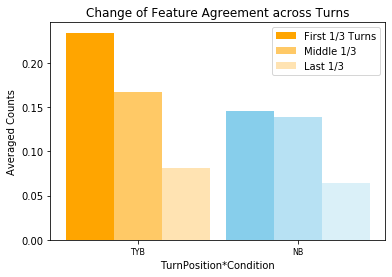

In [281]:
#Feature Agreement
feature_across_turns('aggree_c','Agreement',1)

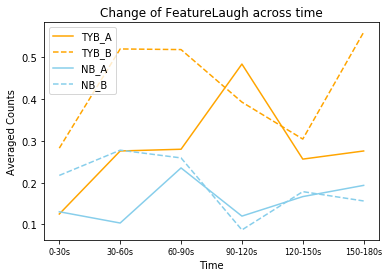

In [256]:
#Feature Laugh
feature_across_time('laugh_c','Laugh',1)

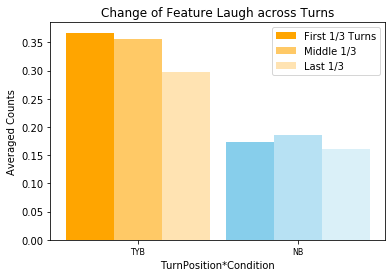

In [282]:
#Feature Laugh
feature_across_turns('laugh_c','Laugh',1)

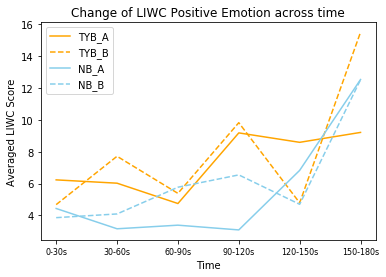

In [264]:
#LIWC Positive Emotion
feature_across_time('posemo','Positive Emotion')

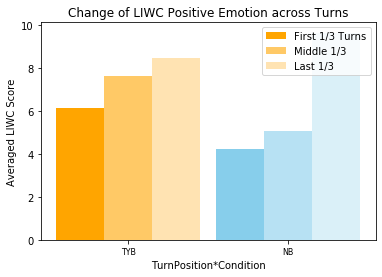

In [283]:
#LIWC Positive Emotion
feature_across_turns('posemo','Positive Emotion')

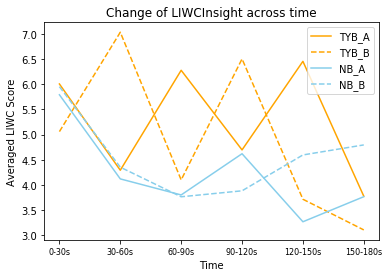

In [252]:
#LIWC Insight
feature_across_time('insight','Insight')

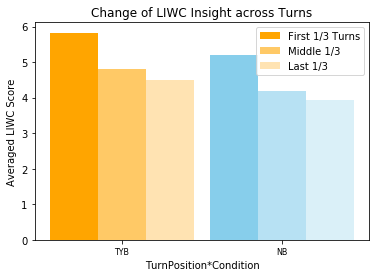

In [284]:
#LIWC Insight
feature_across_turns('insight','Insight')

b. **Word Embeddings Dimension** change across time (180s):

Derive dimensions from word embeddings feature.

In [359]:
#functions to develop dimensions
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [360]:
Affirmation = dimension(model, ['yes','do','okay','yeah'], ['no', 'don\'t', 'not','nope'])
Agreement = dimension(model, ['agree','admit','consent'], ['disagree','differ','dissent'])
Appreciation = dimension(model, ['appreciate','thank','grateful'], ['ingratitude','thankless','ungrateful'])

In [361]:
def simi_affirmation(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Affirmation.reshape(1,-1))[0][0]
    return simi
df_AB0['doc_aff']=df_AB0['doc_vec_g'].apply(lambda x: simi_affirmation(x))
df_AB_turn0['doc_aff']=df_AB_turn0['doc_vec_g'].apply(lambda x: simi_affirmation(x))

In [362]:
def simi_agreement(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Agreement.reshape(1,-1))[0][0]
    return simi
df_AB0['doc_agg']=df_AB0['doc_vec_g'].apply(lambda x: simi_agreement(x))
df_AB_turn0['doc_agg']=df_AB_turn0['doc_vec_g'].apply(lambda x: simi_agreement(x))

In [363]:
def simi_appreciation(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Appreciation.reshape(1,-1))[0][0]
    return simi
df_AB0['doc_app']=df_AB0['doc_vec_g'].apply(lambda x: simi_appreciation(x))
df_AB_turn0['doc_app']=df_AB_turn0['doc_vec_g'].apply(lambda x: simi_appreciation(x))

In [375]:
a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='A')]
aff_sim_A_TYB=list(a['doc_aff'])
avg_aff_sim_A_TYB=sum(aff_sim_A_TYB)/len(aff_sim_A_TYB)

a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='B')]
aff_sim_B_TYB=list(a['doc_aff'])
avg_aff_sim_B_TYB=sum(aff_sim_B_TYB)/len(aff_sim_B_TYB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='A')]
aff_sim_A_NB=list(a['doc_aff'])
avg_aff_sim_A_NB=sum(aff_sim_A_NB)/len(aff_sim_A_NB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='B')]
aff_sim_B_NB=list(a['doc_aff'])
avg_aff_sim_B_NB=sum(aff_sim_B_NB)/len(aff_sim_B_NB)

In [366]:
print('Avg similarity to Affirmation Dimension for A in TYB',round(avg_aff_sim_A_TYB,4))
print('Avg similarity to Affirmation Dimension for B in TYB',round(avg_aff_sim_B_TYB,4))
print('Avg similarity to Affirmation Dimension for A in NB',round(avg_aff_sim_A_NB,4))
print('Avg similarity to Affirmation Dimension for B in NB',round(avg_aff_sim_B_NB,4))

Avg similarity to Affirmation Dimension for A in TYB 0.303
Avg similarity to Affirmation Dimension for B in TYB 0.2991
Avg similarity to Affirmation Dimension for A in NB 0.2875
Avg similarity to Affirmation Dimension for B in NB 0.2913


In [370]:
a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='A')]
aff_sim_A_TYB=list(a['doc_agg'])
avg_agg_sim_A_TYB=sum(aff_sim_A_TYB)/len(aff_sim_A_TYB)

a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='B')]
aff_sim_B_TYB=list(a['doc_agg'])
avg_agg_sim_B_TYB=sum(aff_sim_B_TYB)/len(aff_sim_B_TYB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='A')]
aff_sim_A_NB=list(a['doc_agg'])
avg_agg_sim_A_NB=sum(aff_sim_A_NB)/len(aff_sim_A_NB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='B')]
aff_sim_B_NB=list(a['doc_agg'])
avg_agg_sim_B_NB=sum(aff_sim_B_NB)/len(aff_sim_B_NB)

In [371]:
print('Avg similarity to Agreement Dimension for A in TYB',round(avg_agg_sim_A_TYB,4))
print('Avg similarity to Agreement Dimension for B in TYB',round(avg_agg_sim_B_TYB,4))
print('Avg similarity to Agreement Dimension for A in NB',round(avg_agg_sim_A_NB,4))
print('Avg similarity to Agreement Dimension for B in NB',round(avg_agg_sim_B_NB,4))

Avg similarity to Agreement Dimension for A in TYB 0.1446
Avg similarity to Agreement Dimension for B in TYB 0.1444
Avg similarity to Agreement Dimension for A in NB 0.1443
Avg similarity to Agreement Dimension for B in NB 0.1489


In [372]:
a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='A')]
aff_sim_A_TYB=list(a['doc_app'])
avg_app_sim_A_TYB=sum(aff_sim_A_TYB)/len(aff_sim_A_TYB)

a=df_AB0[(df_AB0['condition']=='TYB') & (df_AB0['agent']=='B')]
aff_sim_B_TYB=list(a['doc_app'])
avg_app_sim_B_TYB=sum(aff_sim_B_TYB)/len(aff_sim_B_TYB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='A')]
aff_sim_A_NB=list(a['doc_app'])
avg_app_sim_A_NB=sum(aff_sim_A_NB)/len(aff_sim_A_NB)

a=df_AB0[(df_AB0['condition']=='NB') & (df_AB0['agent']=='B')]
aff_sim_B_NB=list(a['doc_app'])
avg_app_sim_B_NB=sum(aff_sim_B_NB)/len(aff_sim_B_NB)

In [373]:
print('Avg similarity to Appreciation Dimension for A in TYB',round(avg_app_sim_A_TYB,4))
print('Avg similarity to Appreciation Dimension for B in TYB',round(avg_app_sim_B_TYB,4))
print('Avg similarity to Appreciation Dimension for A in NB',round(avg_app_sim_A_NB,4))
print('Avg similarity to Appreciation Dimension for B in NB',round(avg_app_sim_B_NB,4))

Avg similarity to Appreciation Dimension for A in TYB 0.0806
Avg similarity to Appreciation Dimension for B in TYB 0.0768
Avg similarity to Appreciation Dimension for A in NB 0.0774
Avg similarity to Appreciation Dimension for B in NB 0.0765


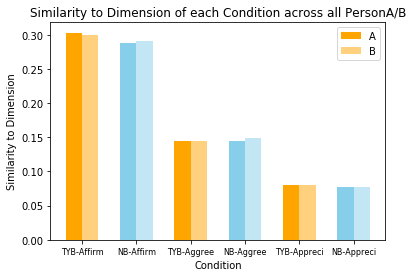

In [376]:
#Plot bar graph, with lines and std for LDA/QDA and each sample size
label0=['TYB-Affirm','NB-Affirm','TYB-Aggree','NB-Aggree','TYB-Appreci','NB-Appreci']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_aff_sim_A_TYB,avg_aff_sim_A_NB,avg_agg_sim_A_TYB,avg_agg_sim_A_NB,avg_app_sim_A_TYB,avg_app_sim_A_NB]
avg_B=[avg_aff_sim_B_TYB,avg_aff_sim_B_NB,avg_agg_sim_B_TYB,avg_agg_sim_B_NB,avg_app_sim_A_TYB,avg_app_sim_A_NB]

colors=['orange','skyblue','orange','skyblue','orange','skyblue']
plt.bar(index,avg_A,width,color=colors,label='A') 
plt.bar(index+width,avg_B,width,color=colors,alpha=0.5,label='B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width/2,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Dimension of each Condition across all PersonA/B');

In [379]:
def dimension_across_time(feat_name,feat_discrip):
    aff_A_TYB=df_AB_turn0[(df_AB_turn0['condition']=='TYB') & (df_AB_turn0['agent']=='A')].groupby('time_label').mean()[feat_name]
    aff_A_TYB=list(aff_A_TYB)
    aff_B_TYB=df_AB_turn0[(df_AB_turn0['condition']=='TYB') & (df_AB_turn0['agent']=='B')].groupby('time_label').mean()[feat_name]
    aff_B_TYB=list(aff_B_TYB)

    aff_A_NB=df_AB_turn0[(df_AB_turn0['condition']=='NB') & (df_AB_turn0['agent']=='A')].groupby('time_label').mean()[feat_name]
    aff_A_NB=list(aff_A_NB)
    aff_B_NB=df_AB_turn0[(df_AB_turn0['condition']=='NB') & (df_AB_turn0['agent']=='B')].groupby('time_label').mean()[feat_name]
    aff_B_NB=list(aff_B_NB)
    
    label0=['0-30s','30-60s','60-90s','90-120s','120-150s','150-180s']
    index=np.arange(len(label0))

    plt.plot(index,aff_A_TYB[:6],color='orange',label='TYB_A')
    plt.plot(index,aff_B_TYB[:6],color='orange',linestyle='dashed',label='TYB_B')
    plt.plot(index,aff_A_NB[:6],color='skyblue',label='NB_A')
    plt.plot(index,aff_B_NB[:6],color='skyblue',linestyle='dashed',label='NB_B')

    plt.xlabel('Time')
    ylabel0='Similarity score to '+feat_discrip
    plt.ylabel(ylabel0)
    plt.xticks(index,label0,FontSize=8)
    plt.legend()
    title0='Similarity to '+feat_discrip+' across time'
    plt.title(title0);

In [391]:
def dimension_across_turns(feat_name,feat_discrip):
    aff_A_TYB=df_AB_turn0[(df_AB_turn0['condition']=='TYB') & (df_AB_turn0['agent']=='A')].groupby('turn_label').mean()[feat_name]
    aff_A_TYB=list(aff_A_TYB)
    aff_B_TYB=df_AB_turn0[(df_AB_turn0['condition']=='TYB') & (df_AB_turn0['agent']=='B')].groupby('turn_label').mean()[feat_name]
    aff_B_TYB=list(aff_B_TYB)

    aff_A_NB=df_AB_turn0[(df_AB_turn0['condition']=='NB') & (df_AB_turn0['agent']=='A')].groupby('turn_label').mean()[feat_name]
    aff_A_NB=list(aff_A_NB)
    aff_B_NB=df_AB_turn0[(df_AB_turn0['condition']=='NB') & (df_AB_turn0['agent']=='B')].groupby('turn_label').mean()[feat_name]
    aff_B_NB=list(aff_B_NB)

    aff_TYB=df_AB_turn0[(df_AB_turn0['condition']=='TYB')].groupby('turn_label').mean()['doc_app']
    aff_TYB=list(aff_TYB)

    aff_NB=df_AB_turn0[(df_AB_turn0['condition']=='NB')].groupby('turn_label').mean()['doc_app']
    aff_NB=list(aff_NB)
    
    label0=['TYB-Turn1','TYB-2','TYB-3','NB-Turn1','NB-2','NB-3']
    index=np.arange(len(label0))
    width=0.3

    avg_A=[aff_A_TYB[0],aff_A_TYB[1],aff_A_TYB[2],aff_A_NB[0],aff_A_NB[1],aff_A_NB[2]]
    avg_B=[aff_B_TYB[0],aff_B_TYB[1],aff_B_TYB[2],aff_B_NB[0],aff_B_NB[1],aff_B_NB[2]]

    colors=['orange','orange','orange','skyblue','skyblue','skyblue']
    plt.bar(index,avg_B,width,color=colors,alpha=0.6,label='Person B')
    plt.bar(index+width,avg_A,width,color=colors,label='Person A') 

    plt.xlabel('TurnPosition*Condition')
    plt.ylabel('Similarity to Dimension')
    plt.xticks(index+width,label0,FontSize=8)
    plt.legend()
    plt.ylim(0,max(max(avg_A),max(avg_B))+0.1)
    title0='Similarity to '+feat_discrip+" Turns by PersonA/B"
    plt.title(title0);

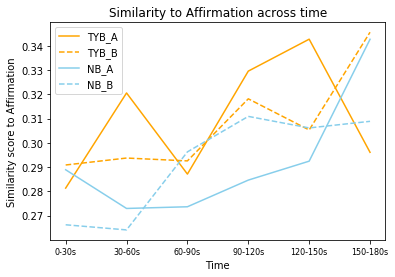

In [380]:
dimension_across_time('doc_aff','Affirmation')

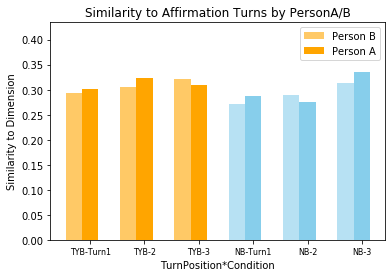

In [392]:
dimension_across_turns('doc_aff','Affirmation')

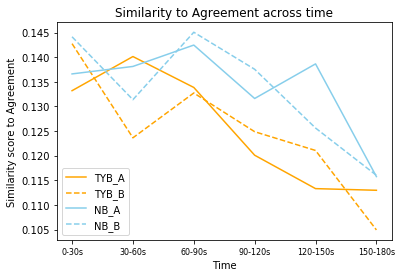

In [393]:
dimension_across_time('doc_agg','Agreement')

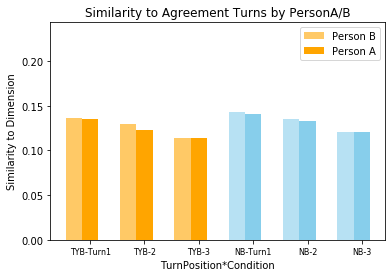

In [394]:
dimension_across_turns('doc_agg','Agreement')

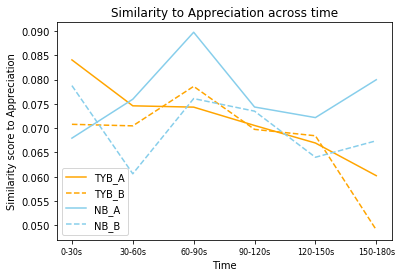

In [395]:
dimension_across_time('doc_app','Appreciation')

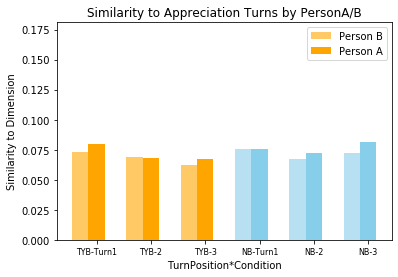

In [396]:
dimension_across_turns('doc_app','Appreciation')

#### Appendix: Sentiment Analysis

In [397]:
from transformers import pipeline

In [398]:
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [399]:
def sentiment_score(sent):
    score0=nlp_sentiment(sent)
    score=score0[0]['score']
    if score0[0]['label']=='NEGATIVE':
        score=score*(-1)
    return score

In [400]:
def get_sent_emoall(sent_list):
    sent_emos=[]
    for sent in sent_list:
        sent_emo0=sentiment_score(sent)
        #print(sent_vect0)
        #sent_vect0=sent_vect0.tolist()
        sent_emos.append(sent_emo0)
    return sent_emos

In [401]:
import spacy
nlp = spacy.load("en")

def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [402]:
df_con2['sent']=df_con2['conversation_txt'].apply(lambda x: sent_tokenize(x))

In [403]:
df_AB_turn['sent']=df_AB_turn['turn_txt'].apply(lambda x: sent_tokenize(x))
df_AB['sent']=df_AB['con_txt'].apply(lambda x: sent_tokenize(x))

In [404]:
df_AB_turn['sent_emo_all']=df_AB_turn['sent'].apply(lambda x: get_sent_emoall(x))
df_AB_turn['sent_emo_avg']=df_AB_turn['sent_emo_all'].apply(lambda x: np.mean(x))

In [405]:
aff_A_TYB=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['agent']=='A')].groupby('time_label').mean()['sent_emo_avg']
aff_A_TYB=list(aff_A_TYB)
aff_B_TYB=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['agent']=='B')].groupby('time_label').mean()['sent_emo_avg']
aff_B_TYB=list(aff_B_TYB)

aff_A_NB=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['agent']=='A')].groupby('time_label').mean()['sent_emo_avg']
aff_A_NB=list(aff_A_NB)
aff_B_NB=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['agent']=='B')].groupby('time_label').mean()['sent_emo_avg']
aff_B_NB=list(aff_B_NB)

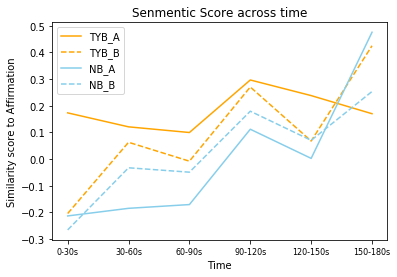

In [411]:
label0=['0-30s','30-60s','60-90s','90-120s','120-150s','150-180s']
index=np.arange(len(label0))

plt.plot(index,aff_A_TYB[:6],color='Orange',label='TYB_A')
plt.plot(index,aff_B_TYB[:6],color='Orange',linestyle='dashed',label='TYB_B')
plt.plot(index,aff_A_NB[:6],color='Skyblue',label='NB_A')
plt.plot(index,aff_B_NB[:6],color='Skyblue',linestyle='dashed',label='NB_B')

plt.xlabel('Time')
plt.ylabel('Similarity score to Affirmation')
plt.xticks(index,label0,FontSize=8)
plt.legend()

plt.title('Senmentic Score across time');

#### Appendix: Import Data for Word Embeddings
*df_con3, df_AB0, df_AB_turn0*

In [312]:
#Load the data info 
import re

text_file='TYB_info.txt'
with open(text_file, encoding='utf-8') as f:
    lines=f.readlines()
    
pair_id=[]
condition=[]
topic=[]

for line in lines[1:]:
    line_sp=line.split('\t')
    pair_id.append(line_sp[0])
    condition.append(line_sp[1])
    topic.append(re.sub(r'\n','',line_sp[2]))

In [313]:
#organize the data info, version3.5
file_num=pair_id
num_of_file=len(file_num)
#condition=['NB','TYB','NB','TYB','TYB','NB','NB','TYB','TYB','TYB','NB']
#topic=[11,11,2,2,5,7,7,13,13,11,11]

conversation_txt_all,conversation_txt_A_all,conversation_txt_B_all,conversation_txt_A_all0,conversation_txt_B_all0=[],[],[],[],[]
round_info_A_all,round_info_B_all,inter_num_A_all,inter_num_B_all,time_info_A_all,time_info_B_all=[],[],[],[],[],[]

# read each file 
for i in range(num_of_file):
    filename='Transcripts/'+file_num[i]+'_otter.ai.txt'
    with open(filename, 'r',encoding='utf-8') as f:  #utf-8
        lines=f.readlines()
    
    conversation_txt,conversation_txt_A,conversation_txt_B=[],[],[]
    round_A,round_B,time0,time_flag_0=0,0,0,0
    time_A,time_B,time_flag_A,time_flag_B,time0_flag=0,0,0,0,0
    time_info_A,time_info_B,round_info_A,round_info_B,inter_num_A,inter_num_B=[],[],[],[],[],[]
    conversation_txt_A_in1,conversation_txt_B_in1=[],[]
    conversation_txt_A_in0,conversation_txt_B_in0='',''
    lineB0,lineA0=[],[]
    inter_A,inter_B=0,0
    l_len=len(lines)
    for i,line in enumerate(lines):
        re_other=r'\[(P|p)erson (A|B):(.*?)\]'
        re_other2=r'\[Speaker (1|2):(.*?)\]'
        find_other=re.findall(re_other,line)
        find_other2=re.findall(re_other2,line)
        line=re.sub(re_other,'.', line)
        line=re.sub(re_other2,'.', line)
        conversation_txt_A_in=[]
        conversation_txt_B_in=[]
        for other in find_other2: #speaker
            other_content=other[1]
            if person_id=='A':
                inter_B+=1
                conversation_txt_B_in.append(other_content)
            elif person_id=='B':
                inter_A+=1
                conversation_txt_A_in.append(other_content)                   

        for other in find_other:
            other_id=other[1]
            other_content=other[2]
            if other_id=='A':
                inter_A+=1
                if len(other_content)>8:
                    conversation_txt_A_in.append(other_content)
                #conversation_txt_A_in.append(other_content)
                #print(conversation_txt_A)
            elif other_id=='B':
                inter_B+=1
                if len(other_content)>8:
                    conversation_txt_B_in.append(other_content)
                #conversation_txt_B_in.append(other_content)
        
        re_person=r'Person (A|B)  (\d:\d{2})'
        find_person=re.findall(re_person,line)
        if find_person:
            person_id=find_person[0][0]
            timestamp0=find_person[0][1]
            c1,c2,c3=int(timestamp0[0]),int(timestamp0[2]),int(timestamp0[3])
            timestamp1=c1*60+c2*10+c3
            if time0_flag==0:
                time0=timestamp1
                time0_flag=1
            if person_id=='A'and time_flag_A==0:
                time_A=timestamp1-time0
                time_flag_A=1
            elif person_id=='B'and time_flag_B==0:
                time_B=timestamp1-time0
                time_flag_B=1
        else:
            line=re.sub(r'\n','',line)
            line=re.sub(r'--',' ',line)
            line=re.sub(r"\"",' ',line)
            line=re.sub(r'Transcribed by https://otter.ai','',line)
            if line:
                line0=line
                if person_id=='A':
                    if len(conversation_txt_B_in)!=0:
                        line0=line0+'.'+'.'.join(conversation_txt_B_in)
                    conversation_txt.append(line0)  
                if person_id=='B':
                    if len(conversation_txt_A_in)!=0:
                        line0=line0+'.'+'.'.join(conversation_txt_A_in)
                    conversation_txt.append(line0)                      
                    
                if len(line)<15:
                    if person_id=='A':
                        conversation_txt_A_in0=conversation_txt_A_in0+'. '+line
                        if len(conversation_txt_B_in0)==0 and len(conversation_txt_B)!=0:
                            lineB0=conversation_txt_B[-1]
                            a=conversation_txt_B.pop()
                            #if a:
                            round_B=round_B-1
                            time_B=time_info_B[-1]
                            time_flag_B=1
                            time_info_B.pop()
                            round_info_B.pop()
                            conversation_txt_B_in0=conversation_txt_B_in0+lineB0+'.'.join(conversation_txt_B_in)
                            
                        else:
                            conversation_txt_B_in0=conversation_txt_B_in0+'.'.join(conversation_txt_B_in)

                    if person_id=='B':
                        conversation_txt_B_in0=conversation_txt_B_in0+'. '+line
                        if len(conversation_txt_A_in0)==0 and len(conversation_txt_A)!=0:
                            lineA0=conversation_txt_A[-1]
                            a=conversation_txt_A.pop()
                            #if a:
                            round_A=round_A-1
                            time_A=time_info_A[-1]
                            time_flag_A=1
                            time_info_A.pop()
                            round_info_A.pop()
                            conversation_txt_A_in0=conversation_txt_A_in0+lineA0+'.'.join(conversation_txt_A_in)
                        else:
                            conversation_txt_A_in0=conversation_txt_A_in0+'.'.join(conversation_txt_A_in)
                        
                    #if person_id=='B':
                        #conversation_txt_B_in0=conversation_txt_B_in0+'. '+line
                        #conversation_txt_A_in0=conversation_txt_A_in0+'.'.join(conversation_txt_A_in)
                else:  
                    conversation_txt_A_in1=conversation_txt_A_in0
                    conversation_txt_B_in1=conversation_txt_B_in0
                    lineB0=0
                    lineA0=0
                    conversation_txt_A_in0='.'.join(conversation_txt_A_in)
                    conversation_txt_B_in0='.'.join(conversation_txt_B_in)    
                    if person_id=='A':
                        round_A+=1
                        round_info_A.append(round_A)
                        inter_num_B.append(inter_B)
                        time_info_A.append(time_A)
                        time_flag_A=0
                        inter_B=0
                        if len(conversation_txt_A_in1)!=0:
                            line=conversation_txt_A_in1+'. '+line
                            conversation_txt_A_in1=[]
                        if len(conversation_txt_B_in1)!=0:
                            conversation_txt_B_in0=conversation_txt_B_in1+'. '+conversation_txt_B_in0
                            conversation_txt_B_in1=[]
                        conversation_txt_A.append(line)
                    elif person_id=='B':
                        round_B+=1
                        round_info_B.append(round_B)
                        inter_num_A.append(inter_A)
                        time_info_B.append(time_B)
                        time_flag_B=0
                        inter_A=0
                        if len(conversation_txt_B_in1)!=0:
                            line=conversation_txt_B_in1+'. '+line
                            conversation_txt_B_in1=[]
                        if len(conversation_txt_A_in1)!=0:
                            conversation_txt_A_in0=conversation_txt_A_in1+'. '+conversation_txt_A_in0
                            conversation_txt_A_in1=[]
                        conversation_txt_B.append(line)
                        
        if i==l_len-1:
            if len(conversation_txt_A_in0)!=0:
                #lineA0=conversation_txt_A[-1]
                #conversation_txt_A.pop()
                #lineA1=lineA0+conversation_txt_A_in0
                conversation_txt_A.append(conversation_txt_A_in0)
                round_A+=1
                round_info_A.append(round_A)
                time_info_A.append(time_A)
            if len(conversation_txt_B_in0)!=0:
                conversation_txt_B.append(conversation_txt_B_in0)
                round_B+=1
                round_info_B.append(round_B)
                time_info_B.append(time_B)
                
    conversation_txt=' '.join(conversation_txt)       
    conversation_txt_A0=' '.join(conversation_txt_A)    
    conversation_txt_B0=' '.join(conversation_txt_B)    
    
    conversation_txt_all.append(conversation_txt)
    conversation_txt_A_all0.append(conversation_txt_A0)
    conversation_txt_B_all0.append(conversation_txt_B0)
    conversation_txt_A_all.append(conversation_txt_A)
    conversation_txt_B_all.append(conversation_txt_B)
    round_info_A_all.append(round_info_A)
    round_info_B_all.append(round_info_B)
    inter_num_A_all.append(inter_num_A)
    inter_num_B_all.append(inter_num_B)
    time_info_A_all.append(time_info_A)
    time_info_B_all.append(time_info_B)

#organize into a dataframe
df_con3=pandas.DataFrame({'condition':condition,'pair_id':pair_id,'topic':topic,'conversation_txt':conversation_txt_all,'con_txt_A':conversation_txt_A_all0,'con_txt_B':conversation_txt_B_all0,'turn_txt_A':conversation_txt_A_all,'turn_txt_B':conversation_txt_B_all,'round_A':round_info_A_all,'round_B':round_info_B_all,'time_A':time_info_A_all,'time_B':time_info_B_all,'inter_num_A':inter_num_A_all,'inter_num_B':inter_num_B_all })

In [314]:
#find the turn number of each Person
df_con3['last_turn1_A']=df_con3['round_A'].apply(lambda x: find_last_turn(x,1))
df_con3['last_turn1_B']=df_con3['round_B'].apply(lambda x: find_last_turn(x,1))

Calculated avergaed turn numbers for each conversation:

In [315]:
df_con3['averaged_turn']=(df_con3['last_turn1_A']+df_con3['last_turn1_B'])/2

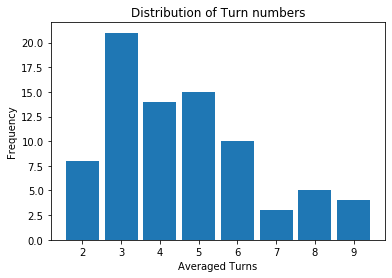

In [316]:
plt.hist(x=df_con3['averaged_turn'], bins='auto', rwidth=0.85);
plt.xlabel('Averaged Turns');
plt.ylabel('Frequency');
plt.title('Distribution of Turn numbers');

Averaged turn number for the whole corpora

In [317]:
np.mean(df_con3['averaged_turn'])

4.35

#### Organize DataFrame for each Turn

* Utterance of each turn is a single row:

In [319]:
#For each round 
index_all_A,condition_all_A,pair_all_A,topic_all_A,turn_txt_A_all,round_A_all,inter_A_all,time_A_all=[],[],[],[],[],[],[],[]
index_all_B,condition_all_B,pair_all_B,topic_all_B,turn_txt_B_all,round_B_all,inter_B_all,time_B_all=[],[],[],[],[],[],[],[]

for index, row in df_con3.iterrows():
    index0=index
    condition0=row['condition']
    pair0=row['pair_id']
    topic0=row['topic']
    turn_A=len(row['round_A'])
    turn_B=len(row['round_B'])
    time_A=row['time_A']
    time_B=row['time_B']
    
    index_all_A.extend([index0]*turn_A)
    pair_all_A.extend([pair0]*turn_A)
    topic_all_A.extend([topic0]*turn_A)
    condition_all_A.extend([condition0]*turn_A)
    time_A_all.extend(time_A)
    time_B_all.extend(time_B)
    turn_txt_A=row['turn_txt_A']
    turn_txt_A_all.extend(turn_txt_A[:turn_A])
    round_A_all.extend(row['round_A'])
    inter_A=row['inter_num_A']
    if len(inter_A)<turn_A:
        inter_A.extend([0]*(turn_A-len(inter_A)))
    inter_A_all.extend(inter_A[:turn_A])
    
    index_all_B.extend([index0]*turn_B)
    pair_all_B.extend([pair0]*turn_B)
    topic_all_B.extend([topic0]*turn_B)
    condition_all_B.extend([condition0]*turn_B)
    turn_txt_B=row['turn_txt_B']
    turn_txt_B_all.extend(turn_txt_B[:turn_B])
    #turn_txt_B_all.extend(row['turn_txt_B'])
    round_B_all.extend(row['round_B'])
    inter_B=row['inter_num_B']
    if len(inter_B)<turn_B:
        inter_B.extend([0]*(turn_B-len(inter_B)))
    inter_B_all.extend(inter_B[:turn_B])
    #inter_B_all.extend(row['inter_num_B'][:turn_B])
    
df_A0=pandas.DataFrame({'index':index_all_A,'condition':condition_all_A,'pair_id':pair_all_A,'topic':topic_all_A,'turn_txt':turn_txt_A_all,'round':round_A_all,'time':time_A_all,'inter_num':inter_A_all})
df_B0=pandas.DataFrame({'index':index_all_B,'condition':condition_all_B,'pair_id':pair_all_B,'topic':topic_all_B,'turn_txt':turn_txt_B_all,'round':round_B_all,'time':time_B_all,'inter_num':inter_B_all})

In [320]:
import lucem_illud_2020
df_A0['tokenized_text'] = df_A0['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_A0['word_counts'] = df_A0['tokenized_text'].apply(lambda x: len(x))
df_B0['tokenized_text'] = df_B0['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_B0['word_counts'] = df_B0['tokenized_text'].apply(lambda x: len(x))

In [322]:
df_A0['agent']=['A']*len(df_A0)
df_B0['agent']=['B']*len(df_B0)

In [323]:
df_AB_turn0=pandas.concat([df_A0,df_B0])
df_AB_turn0=df_AB_turn0.reset_index(drop=True)
df_AB_turn0

,index,condition,pair_id,topic,turn_txt,round,time,inter_num,tokenized_text,word_counts,agent
0,0,NB,5,11,"Yeah, like definitely, like, I definitely see ...",1,43,0,"[Yeah, like, definitely, like, I, definitely, ...",229,A
1,0,NB,5,11,And then the other thing is like from like a m...,2,104,0,"[And, then, the, other, thing, is, like, from,...",169,A
2,1,TYB,6,2,"Oh really, Okay, uhhm so I-I think the reason ...",1,0,0,"[Oh, really, Okay, uhhm, so, I, I, think, the,...",88,A
3,1,TYB,6,2,"Yeah, I know. I totally agree with the practic...",2,58,0,"[Yeah, I, know, I, totally, agree, with, the, ...",51,A
4,1,TYB,6,2,. Uh-huh. . There might be like some cost to d...,3,88,0,"[Uh, huh, There, might, be, like, some, cost, ...",69,A
...,...,...,...,...,...,...,...,...,...,...,...
691,79,TYB,108,15,"that makes sense. right, for disagree. Okay, ...",2,54,0,"[that, makes, sense, right, for, disagree, Oka...",27,B
692,79,TYB,108,15,"Oh, are you saying that, are you saying that. ...",3,63,3,"[Oh, are, you, saying, that, are, you, saying,...",39,B
693,79,TYB,108,15,Test on human. that makes sense. But then agai...,4,103,0,"[Test, on, human, that, makes, sense, But, the...",46,B
694,79,TYB,108,15,"That' s so funny. I just popped in like, what ...",5,123,2,"[That, s, so, funny, I, just, popped, in, like...",16,B


In [325]:
df_AB_turn0['time_label']=df_AB_turn0['time'].apply(lambda x: time_label(x))

In [326]:
time_label_countPcate=df_AB_turn0.groupby('time_label').count()['index']

In [327]:
time_label_countPcate

time_label
1    147
2     99
3     94
4    101
5    141
6    113
7      1
Name: index, dtype: int64

##### Tag Turn Label:

Tag turn label, according to their positions in the conversation, divide into 3 parts: 
    for example, for a 3 turns conversation: tag turn1 as 1, turn2 as 2, turn3 as 3.
    for a 5 turns conversation: tag turn1/2 as 1, turn3/4 as 2, turn5 as 3.


In [329]:
turn_label_all=[]
for index, row in df_AB_turn0.iterrows(): 
    agent=row['agent']
    pair_id=row['pair_id']
    current_r=row['round']
    turn_A_num=len(df_con3[df_con3['pair_id']==pair_id]['round_A'].values[0])
    turn_B_num=len(df_con3[df_con3['pair_id']==pair_id]['round_B'].values[0])
    turn_len=min(turn_A_num,turn_B_num)
    
    if turn_len==2:
        if current_r==1:
            turn_label_all.append(1)
        else:
            turn_label_all.append(2)
    elif turn_len==3:
        if current_r==1:
            turn_label_all.append(1)
        elif current_r==2:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)
    elif turn_len==4:
        if current_r==1:
            turn_label_all.append(1)
        elif current_r in [2,3]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)            
    elif turn_len==5 or turn_len==6:
        if current_r in [1,2]:
            turn_label_all.append(1)
        elif current_r in [3,4]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)       
    elif turn_len==7:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)   
    elif turn_len==8 or turn_len==9:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5,6]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3)  
    elif turn_len==10:
        if current_r in [1,2,3]:
            turn_label_all.append(1)
        elif current_r in [4,5,6,7]:
            turn_label_all.append(2)
        else:
            turn_label_all.append(3) 
    elif turn_len==1:
        if current_r==1:
            turn_label_all.append(1)
        else:
            turn_label_all.append(2)

In [330]:
df_AB_turn0['turn_label']=turn_label_all

Number of Turns under each turn label:

In [331]:
turn_label_countPcate=df_AB_turn0.groupby('turn_label').count()['index']
turn_label_countPcate

turn_label
1    236
2    267
3    193
Name: index, dtype: int64

#### Organize for each Agent:

* Each agent (A/B) is a single row:

In [332]:
#extract corpora of each speaker and organize into one list/dataframe
A_cop=[]
A_con=[]
A_topic=[]
for index, row in df_con3.iterrows():
    A_cop.append(row['con_txt_A'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_A'])
    A_cop.append(row['con_txt_B'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_B'])

In [333]:
label=[]
for i in range(len(df_con3)):
    label.append('A_'+str(i+1))
    label.append('B_'+str(i+1))

In [334]:
df_AB0=pandas.DataFrame({'con_txt':A_cop,'condition':A_con,'label':label,'topic':A_topic})

In [335]:
def get_agent(labelab):
    agent=labelab[0]
    return agent
df_AB0['agent']=df_AB0['label'].apply(lambda x: get_agent(x))
df_AB0.head()

,con_txt,condition,label,topic,agent
0,"Yeah, like definitely, like, I definitely see ...",NB,A_1,11,A
1,I actually didn't look much into the legal sys...,NB,B_1,11,B
2,"Oh really, Okay, uhhm so I-I think the reason ...",TYB,A_2,2,A
3,I think I really like your concern about the n...,TYB,B_2,2,B
4,"So I, when I read this question I thought abou...",NB,A_3,5,A
